# CNN

In [1]:
import tensorflow.keras as keras

In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from pylab import rcParams
from scipy import stats
from sklearn import metrics
import seaborn as sns
from sklearn import preprocessing
import os as os
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
from time import time

%matplotlib inline

In [3]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)
tf.__version__

/usr/bin/python
3.6.8 (default, Aug 20 2019, 17:12:48) 
[GCC 8.3.0]
sys.version_info(major=3, minor=6, micro=8, releaselevel='final', serial=0)


'1.14.0'

In [4]:
keras.__version__

'2.2.4-tf'

# 10-FOLD

In [5]:
# Sujetos utilizados
subjects = ['01', '02', '03', '05', '08', '09', '10', '11', '13', '14', '16', '17']
# Actividades utilizadas
global activities
activities = [9,10,11,12,13,19,20,21,24,25,31]

### Hiperparámetros

In [6]:
n_time_steps = 128 # Tamaño de cada instancia de ejemplo (cada una tendrá un tamaño de [128,40])
n_columns = 40 # Nº de features
n_classes = 11 # Nº de clases
n_channels = 1 # Nº de canales


batch_size = 128 # Tamaño del batch
learning_rate = 1e-3 # Learning rate
epochs = 100 # Épocas

### Decaimiento de la learning rate

In [7]:
class LearningRateDecay:
    
    def plot(self, epochs, title="Learning Rate Schedule"):
        # Cálculo del conjunto de learning rates para cada época
        lrs = [self(i) for i in epochs]
 
        #Visualización de la learning rate
        plt.style.use("ggplot")
        plt.figure()
        plt.plot(epochs, lrs)
        plt.title(title)
        plt.xlabel("Epoch #")
        plt.ylabel("Learning Rate")
        
class StepDecay(LearningRateDecay):
    def __init__(self, initAlpha=0.01, factor=0.25, dropEvery=10):
        # Almacenamiento de la learning rate inicial, el factor de decaimiento
        # y las épocas tras las que realizar el decaimiento
        self.initAlpha = initAlpha
        self.factor = factor
        self.dropEvery = dropEvery
 
    def __call__(self, epoch):
        # Cálculo de la learning rate para la época actual
        exp = np.floor((1 + epoch) / self.dropEvery)
        alpha = self.initAlpha * (self.factor ** exp)
        if(alpha<1e-9):
            alpha=1e-9

        return float(alpha) 

schedule = StepDecay(initAlpha=learning_rate, factor=0.4, dropEvery=10)

reduce_lr = keras.callbacks.LearningRateScheduler(schedule, verbose = 1)
callbacks_list = [reduce_lr]

### Funciones de visualización 

In [8]:
# Visualización de la evolución del entrenamiento
def plot_curves(model, acc, loss, val_acc, val_loss, kfold):
    #########################################################################################
    # LOSS plot
    plt.figure(figsize=(12,8))
    plt.plot(model.history.history[loss], label='Training loss')
    plt.xlabel('Epochs', fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.tick_params(labelsize=10)
    plt.legend(loc=1,prop={'size': 10})
    plt.title('Loss in trainnig', fontsize=20)
    fig = plt.gcf()
    plt.show()
    
    fig.savefig('./000_1_AUGNORMFFT_RP/loss_train_000_1_AUGNORMFFT_RP_KFOLD_'+kfold+'.pdf', bbox_inches='tight',format='pdf')
    fig.savefig('./000_1_AUGNORMFFT_RP/loss_train_000_1_AUGNORMFFT_RP_KFOLD_'+kfold+'svg', bbox_inches='tight',format='svg')
    
    #########################################################################################
    # ACC plot
    plt.figure(figsize=(12,8))
    plt.plot(model.history.history[acc], label='Training accuracy')
    plt.xlabel('Epochs', fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.tick_params(labelsize=10)
    plt.legend(loc=1,prop={'size': 10})
    plt.title('Accuracy in training', fontsize=20)
    fig = plt.gcf()
    plt.show()

    fig.savefig('./000_1_AUGNORMFFT_RP/acc_train_000_1_AUGNORMFFT_RP_KFOLD_'+kfold+'pdf', bbox_inches='tight',format='pdf')
    fig.savefig('./000_1_AUGNORMFFT_RP/acc_train_000_1_AUGNORMFFT_RP_KFOLD_'+kfold+'svg', bbox_inches='tight',format='svg')
    
    #########################################################################################
    # ACC+LOSS plot
    plt.figure(figsize=(14,10))
    plt_loss = host_subplot(111, axes_class=AA.Axes)
    plt.subplots_adjust(right=0.75)

    plt_acc = plt_loss.twinx()
    plt_acc.axis["right"].toggle(all=True)
    
    plt_loss.set_xlim(0, len(model.history.history[loss]))
    plt_loss.set_ylim(0, max(model.history.history[loss]))
    plt_loss.set_xlabel('Epochs')
    plt_loss.set_ylabel('Loss')
    plt_acc.set_ylabel('Accuracy')
                        
    plt_loss.axis['left'].label.set_fontsize(15)
    plt_loss.axis['bottom'].label.set_fontsize(15)
    plt_acc.axis['right'].label.set_fontsize(15)
    
    plt_loss.plot(model.history.history[loss], c='tab:blue', ls='--', label='Training loss')
    plt_acc.plot(model.history.history[acc], c='tab:orange',ls='--', label='Training accuracy')
    
    plt.tick_params(labelsize=10)
    plt.title('Training performance', fontsize=20)
    plt_acc.set_ylim(0, 1)
    plt_loss.legend(loc=1, prop={'size': 10})
    
    fig = plt.gcf()
    plt.show()

    fig.savefig('./000_1_AUGNORMFFT_RP/all_train_000_1_AUGNORMFFT_RP_KFOLD_'+kfold+'pdf', bbox_inches='tight',format='pdf')
    fig.savefig('./000_1_AUGNORMFFT_RP/all_train_000_1_AUGNORMFFT_RP_KFOLD_'+kfold+'svg', bbox_inches='tight',format='svg')

In [9]:
# Plot de la matriz de confusión
def plot_confusion_matrix(y_true, y_pred, kfold, classes,
                          cmap=plt.cm.Blues):

    # Cálculo de la matriz de confusión
    cm = metrics.confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(20, 20))
    sns.heatmap(cm, xticklabels=classes, yticklabels=classes, square = True, robust = True, annot=True, cmap='YlOrBr')
    plt.title('CONFUSION MATRIX')
    plt.ylabel('TRUE ACTIVITY')
    plt.xlabel('PREDICTION')
    
    locs, labels = plt.xticks()
    plt.xticks(locs, labels, rotation='vertical')
    locs, labels = plt.yticks()
    plt.yticks(locs, labels, rotation='horizontal')

    # Guardamos la imagen en formato vectorial
    plt.draw()
    plt.savefig('./000_1_AUGNORMFFT_RP/matriz_confusion_'+kfold+'.svg', bbox_inches='tight',format='svg')
    plt.show()

### Generación del K-Fold

In [10]:
global size
size = 26125 # número de instancias

In [11]:
from sklearn.model_selection import KFold
S = np.arange(0,size)
kf = KFold(n_splits=10)
kf.get_n_splits(S)

print(kf)  

S_train = []
S_test = []

for train_index, test_index in kf.split(S):
    print("TRAIN:", train_index, "TEST:", test_index)
    print(S[train_index])
    print(S[test_index])
    S_train.append(S[train_index])
    S_test.append(S[test_index])

KFold(n_splits=10, random_state=None, shuffle=False)
TRAIN: [ 2613  2614  2615 ... 26122 26123 26124] TEST: [   0    1    2 ... 2610 2611 2612]
[ 2613  2614  2615 ... 26122 26123 26124]
[   0    1    2 ... 2610 2611 2612]
TRAIN: [    0     1     2 ... 26122 26123 26124] TEST: [2613 2614 2615 ... 5223 5224 5225]
[    0     1     2 ... 26122 26123 26124]
[2613 2614 2615 ... 5223 5224 5225]
TRAIN: [    0     1     2 ... 26122 26123 26124] TEST: [5226 5227 5228 ... 7836 7837 7838]
[    0     1     2 ... 26122 26123 26124]
[5226 5227 5228 ... 7836 7837 7838]
TRAIN: [    0     1     2 ... 26122 26123 26124] TEST: [ 7839  7840  7841 ... 10449 10450 10451]
[    0     1     2 ... 26122 26123 26124]
[ 7839  7840  7841 ... 10449 10450 10451]
TRAIN: [    0     1     2 ... 26122 26123 26124] TEST: [10452 10453 10454 ... 13062 13063 13064]
[    0     1     2 ... 26122 26123 26124]
[10452 10453 10454 ... 13062 13063 13064]
TRAIN: [    0     1     2 ... 26122 26123 26124] TEST: [13065 13066 13067 ... 

# EJECUCIÓN DEL 10-FOLD

##################################################################################################################################
#####################################################  K-FOLD 1  ################################################################
Train dataset: 
(23512, 1, 128, 40) (23512, 11)
Test dataset: 
(2613, 1, 128, 40) (2613, 11)


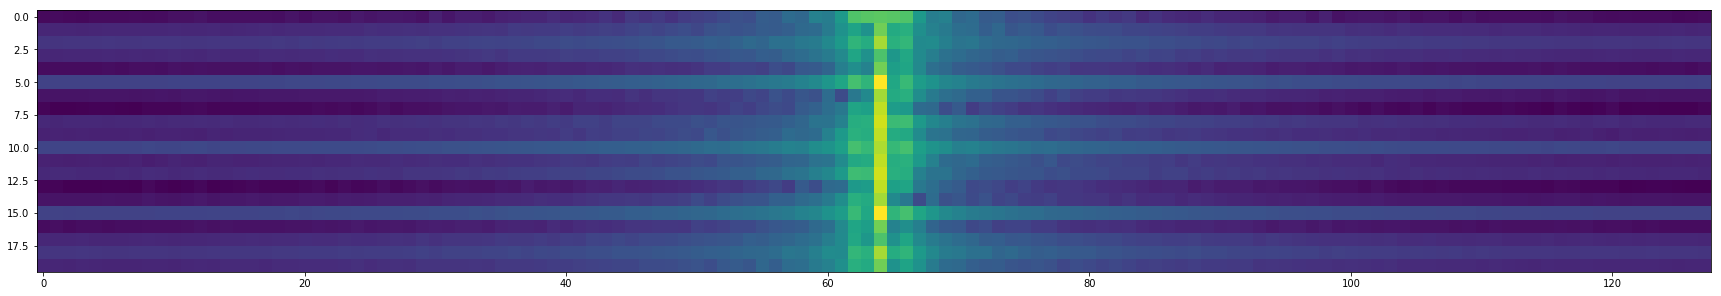

Activity:  12


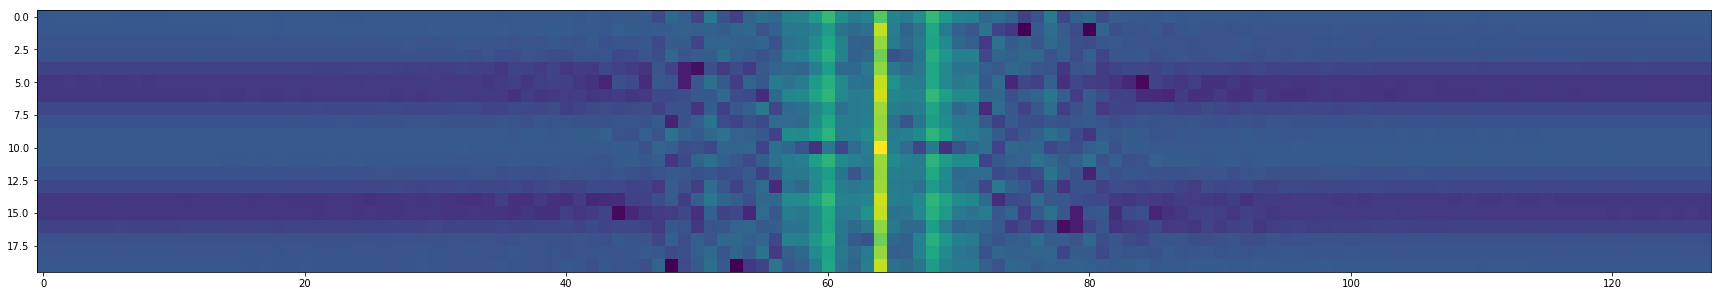

Activity:  25
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1, 128, 40)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 128, 40)       272       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 64, 20)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 64, 20)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 64, 20)        8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 10)        0       

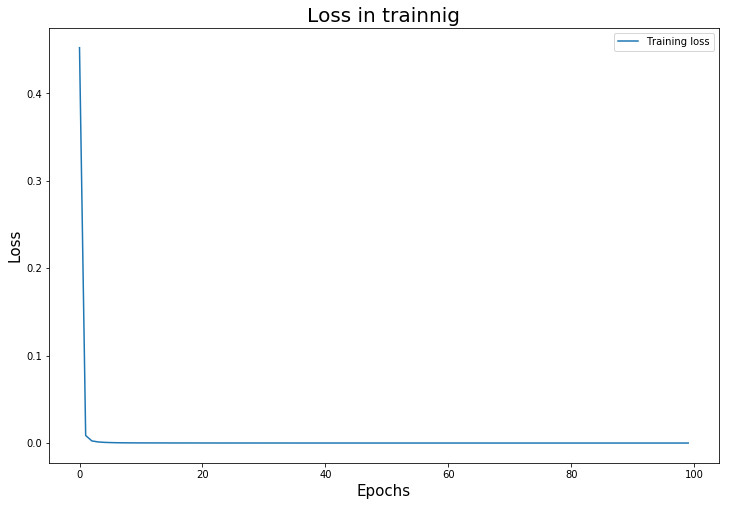

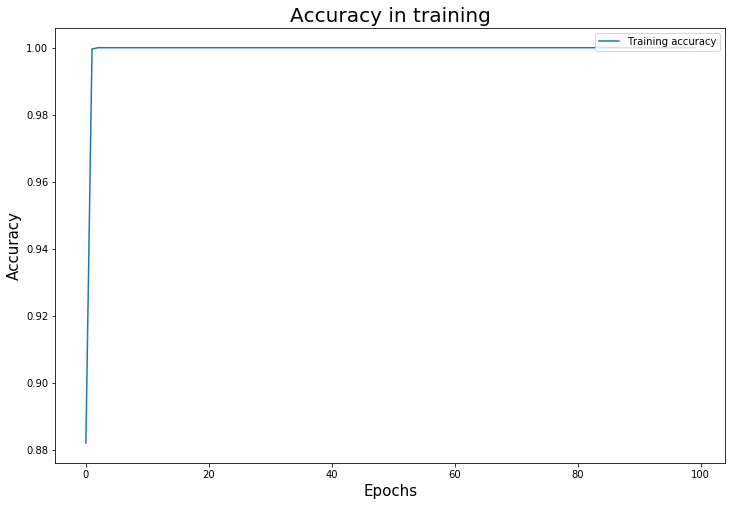

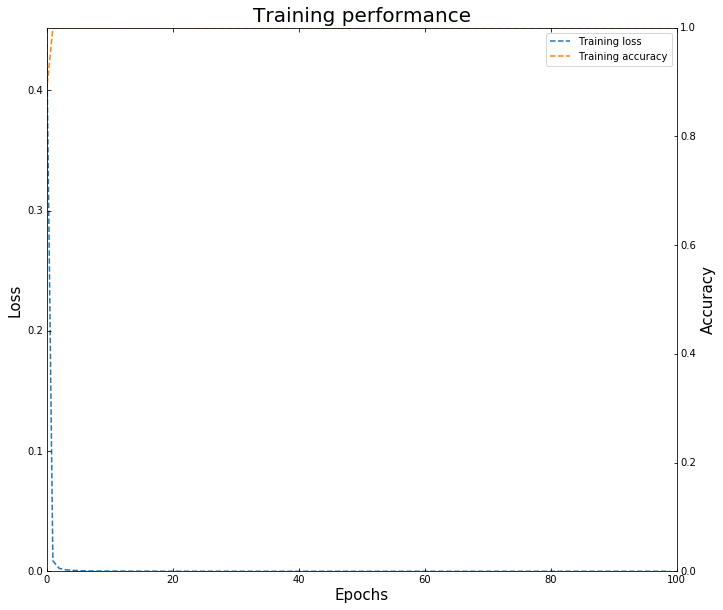

2613/2613 [==============================] - 0s 100us/sample
(2613, 11)
[[ 4 10  3  4  5  6  4  8  4  7  9 10  8  4  8  5  1  5  5  1  9 10 10  4
   3  9  2  4  0  0  9  4  0  5  5 10  4  5  0  9  8  8  9  1  1  7  6  7
   1  1  4  6  2  4  2  8  2  5  4  8  6  3  0  9  0 10  5  9  7 10  6  1
   6  7  5  2  2  8  1  9  7 10 10  1  3  6  3  3  1  1  8  4  0  0 10  3
   8  0  4  2]]
(2613, 1)
[[ 4 10  3  4  5 10  4  8  4  7  9 10  8  4  8  5  1  5  5  1  9 10 10  4
   3  9  2  4  0  0  9  4  0  5  5 10  4  5  6  9  8  8  9  1  1  7  6  7
   1  1  4  6  2  4  2  8  2  6  4  8  2  3  0  9  0 10  5  9  7 10  6  1
   6  7  5  2  2  8  1  9  7 10 10  1  1  6  3  3  1  1  9  4  0  0 10  1
   9  0  4  2]]
2613/2613 [==============================] - 0s 109us/sample - loss: 0.2909 - categorical_accuracy: 0.9342


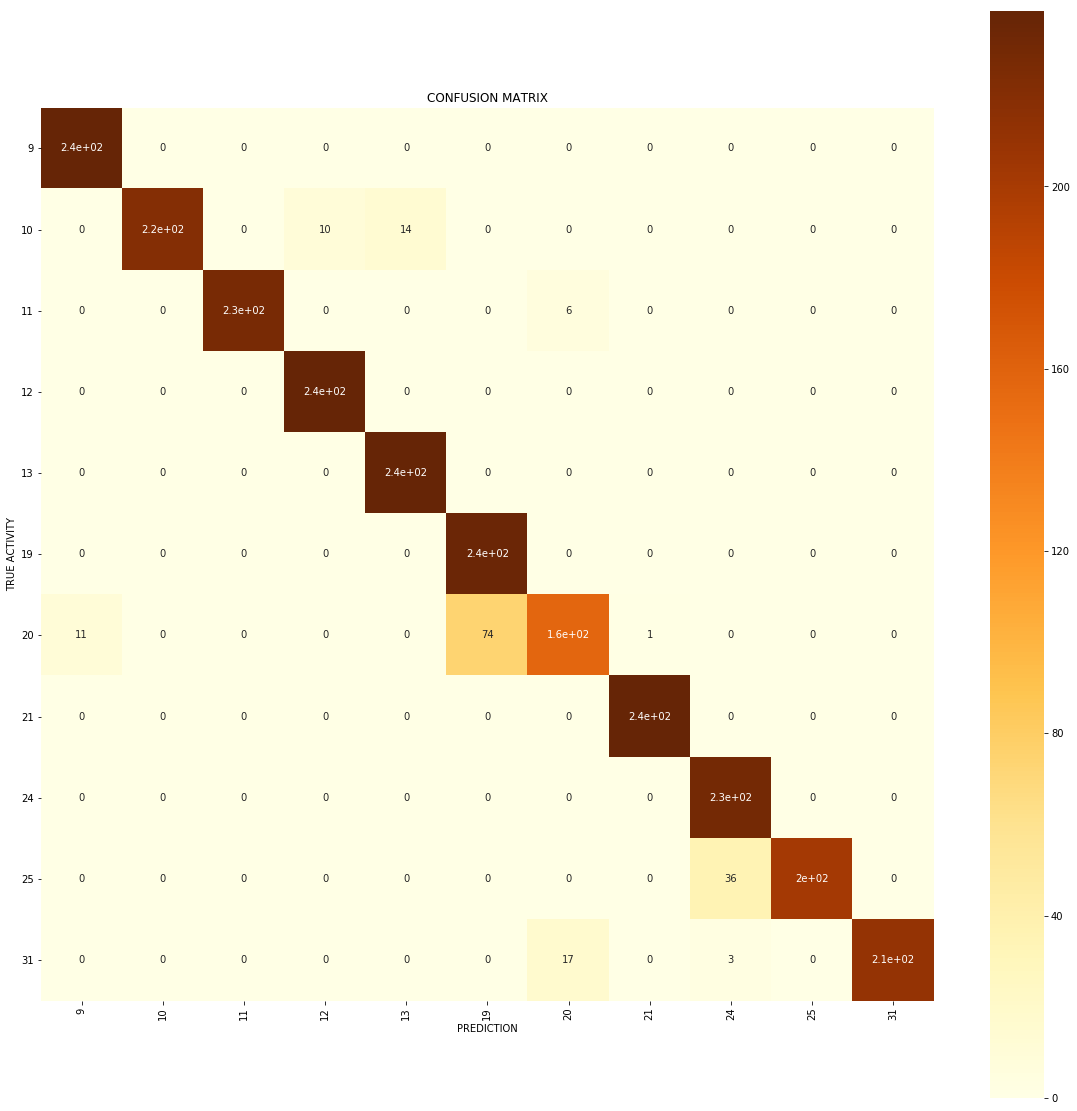

##################################################################################################################################
#####################################################  K-FOLD 2  ################################################################
Train dataset: 
(23512, 1, 128, 40) (23512, 11)
Test dataset: 
(2613, 1, 128, 40) (2613, 11)


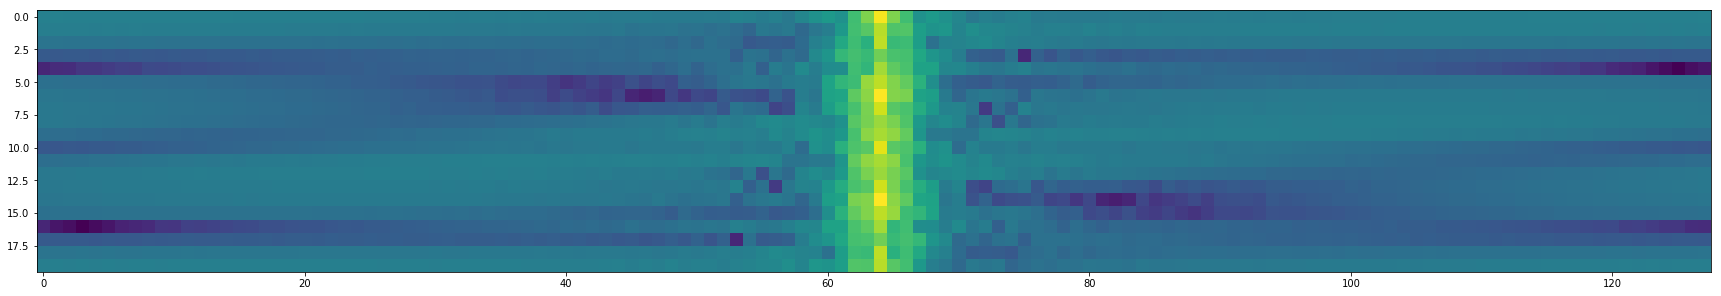

Activity:  13


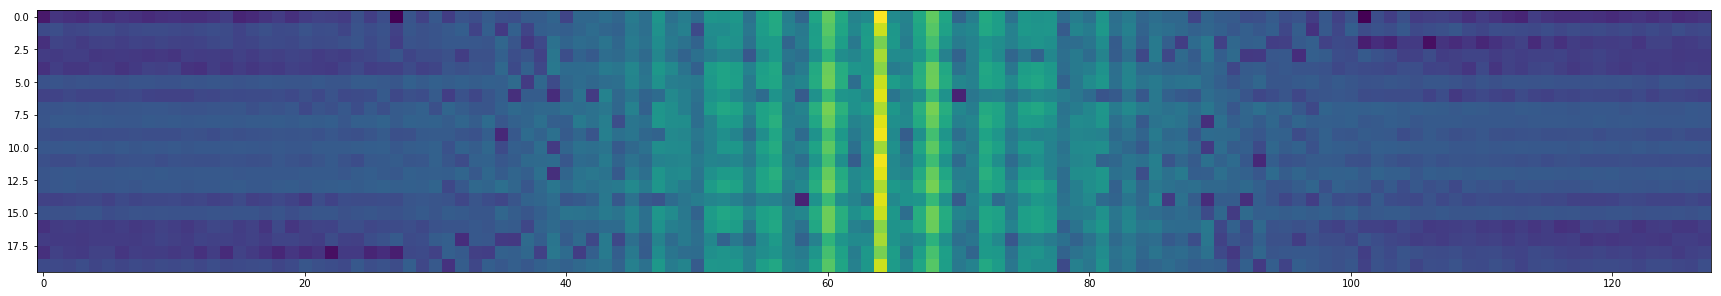

Activity:  25
Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1, 128, 40)]      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 128, 40)       272       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 64, 20)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 64, 20)        64        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 64, 20)        8224      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 10)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10240)       

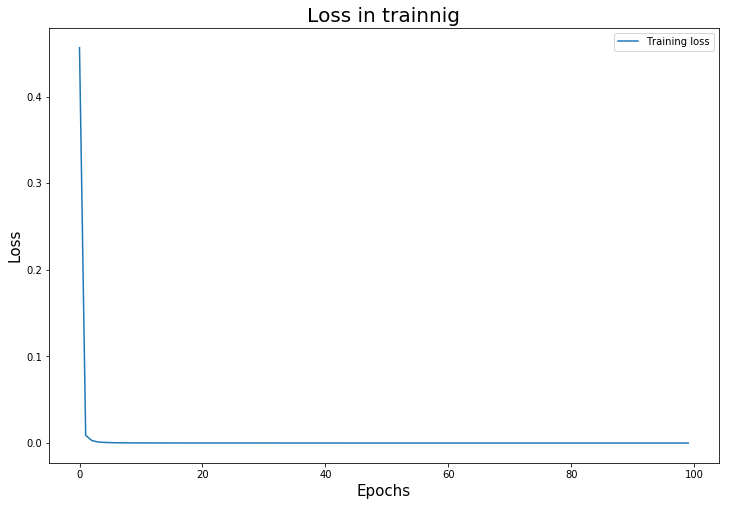

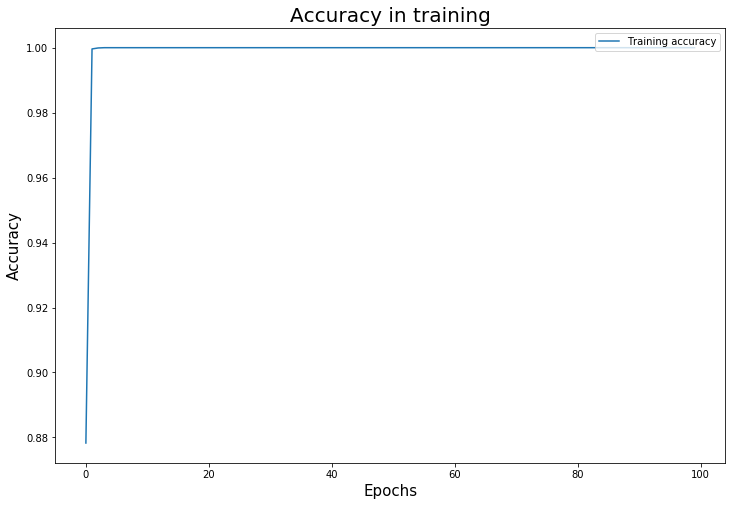

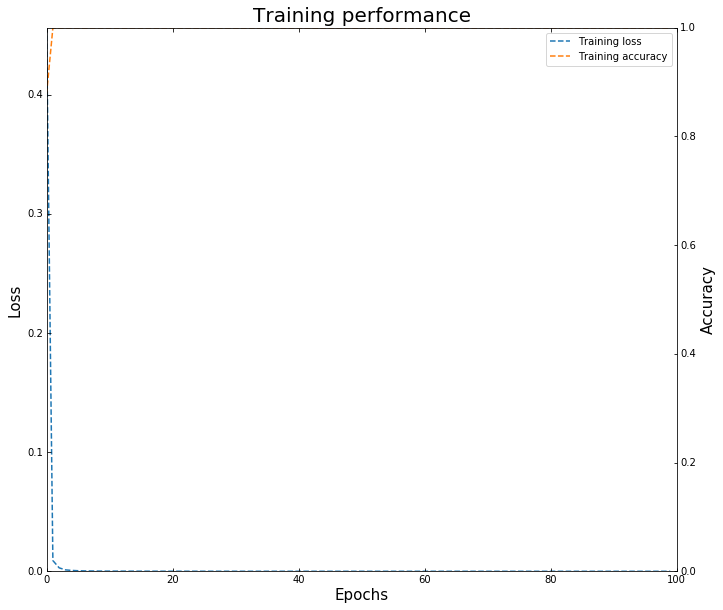

2613/2613 [==============================] - 0s 82us/sample
(2613, 11)
[[ 3  1  7 10  7  3 10  8  4  1  9  6  0  3  4  1 10  9 10  9  9  8  8  7
   8 10  5  5  9  8  4  4  7  5 10  9  0  7 10  5  9  1  4  1  0 10  9  7
   0  2  6  0  2  3  5  1  7  6  7  9  7  3  8  2  2  0  3  4  0  4  8  1
   8  6  4  5  3  5  0  3  9  2  7  4 10  6  6  8 10  6  2  6  8  2  9  6
   9  4  6 10]]
(2613, 1)
[[ 3  1  7 10  7  3 10  8  4  1  9  6  0  3  4  1 10  9 10  9  9  8  8  7
   8 10  5  5  9  8  4  4  7  5 10  9  0  7 10  5  9  1  4  1  0 10  9  7
   0  2  6  0  2  3  5  1  7  6  7  9  7  3  8  2  2  0  3  4  0  4  8  1
   8  6  4  5  3  5  0  3  9  2  7  4 10  6  6  8 10  6  2  6  8  2  9  6
   9  4  6 10]]
2613/2613 [==============================] - 0s 101us/sample - loss: 5.0596e-04 - categorical_accuracy: 1.0000


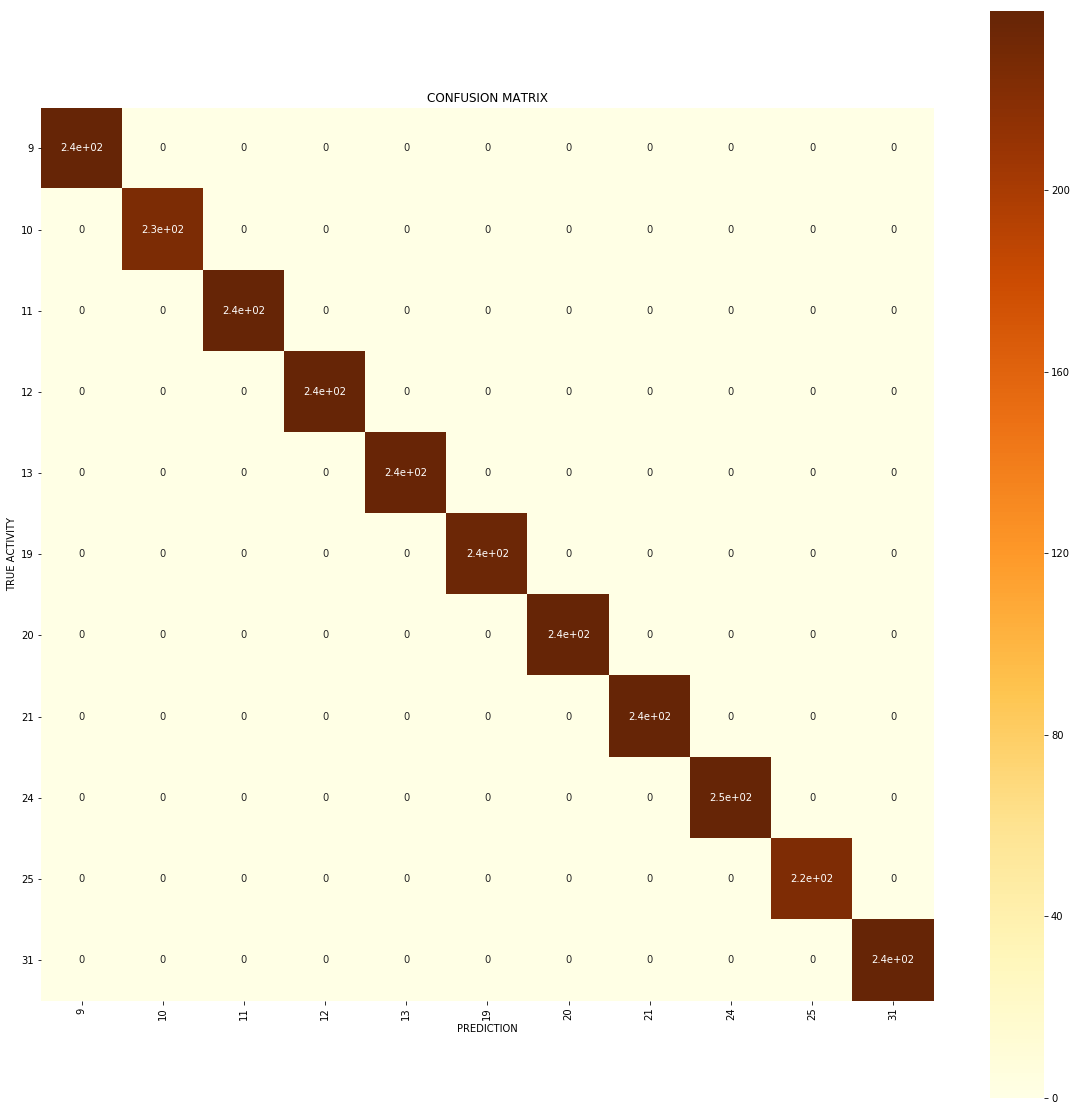

##################################################################################################################################
#####################################################  K-FOLD 3  ################################################################
Train dataset: 
(23512, 1, 128, 40) (23512, 11)
Test dataset: 
(2613, 1, 128, 40) (2613, 11)


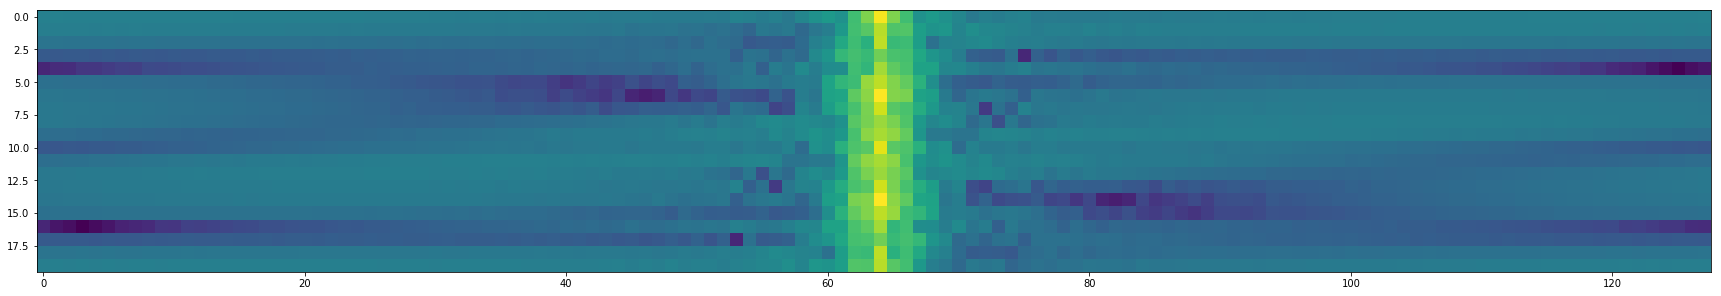

Activity:  13


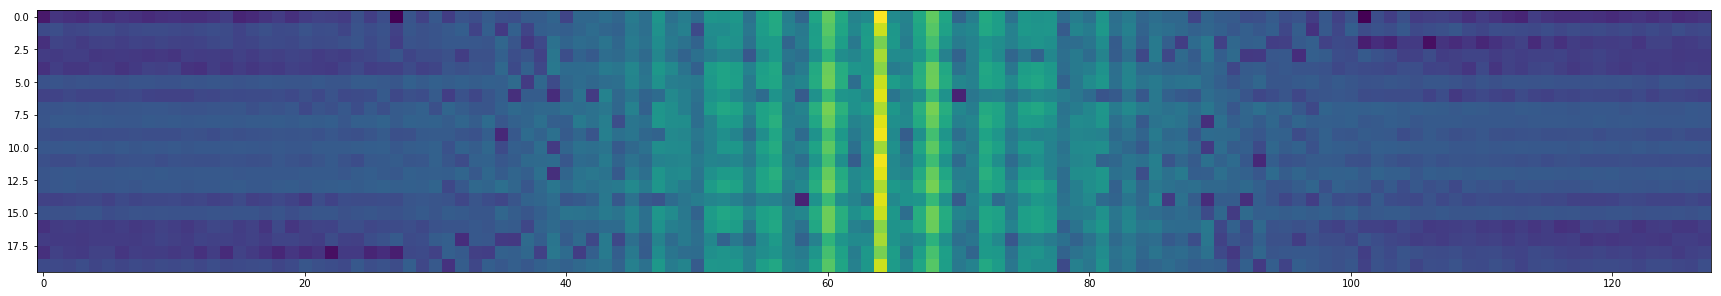

Activity:  25
Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1, 128, 40)]      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 128, 40)       272       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 64, 20)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 64, 20)        64        
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 64, 20)        8224      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 10)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 10240)       

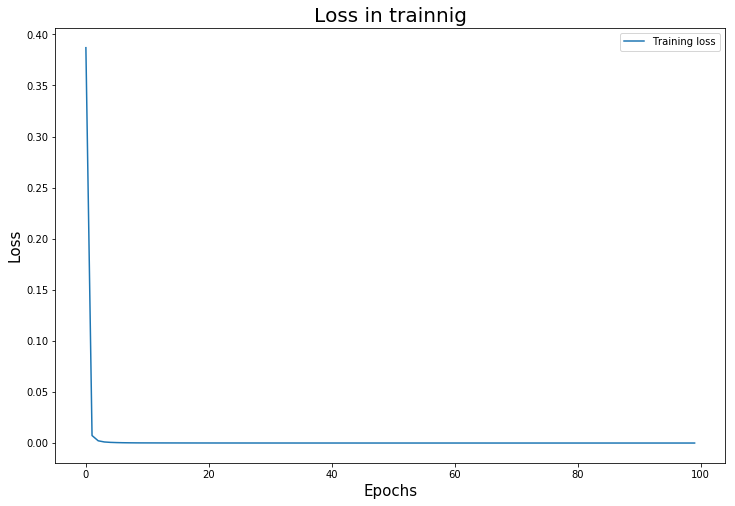

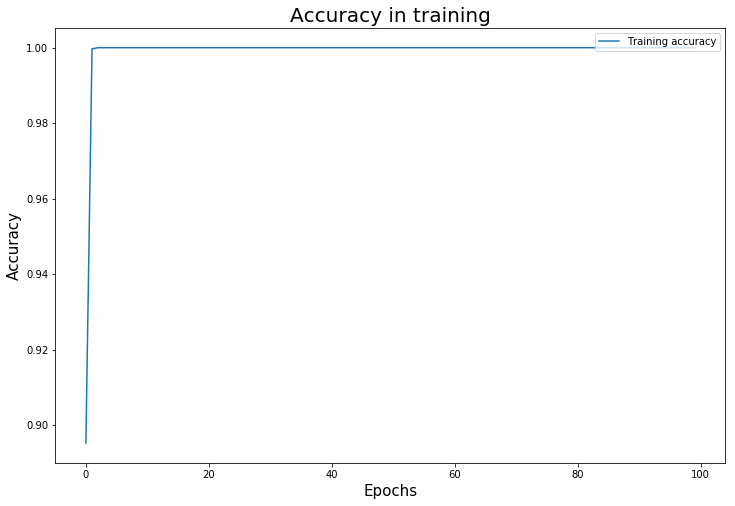

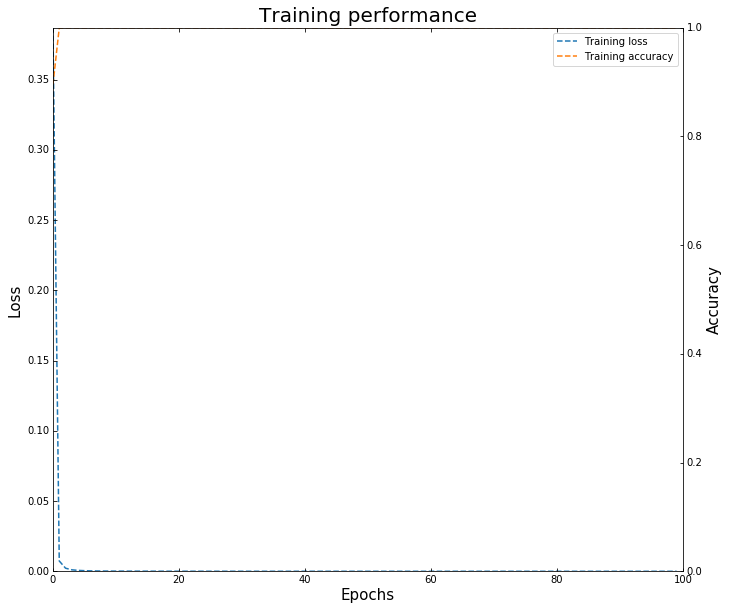

2613/2613 [==============================] - 0s 91us/sample
(2613, 11)
[[ 2  1  0  3  0  1  3  9  3  6 10  8  5  4  2  2  1  0  0  9  5  6  9  4
   4  7  1  6  7  5 10 10  8  0  1  4  7  8  5  2  8 10  9  9  7  8 10 10
   3  6  3  7  4  0 10  5  3  4  6  7  5  2  6  2  2  4  9  7  6 10  7  3
   4  8  6 10  6  2  1  1  8 10  3  7  0  9  8  9  3  5  7  4  3  7 10  2
   0 10  7  5]]
(2613, 1)
[[ 2  1  0  3  0  1  3  9  3  6 10  8  5  4  2  2  1  0  0  9  5  6  9  4
   4  7  1  6  7  5 10 10  8  0  1  4  7  8  5  2  8 10  9  9  7  8 10 10
   3  6  3  7  4  0 10  5  3  4  6  7  5  2  6  2  2  4  9  7  6 10  7  3
   4  8  6 10  6  2  1  1  8 10  3  7  0  9  8  9  3  5  7  4  3  7 10  2
   0 10  7  5]]
2613/2613 [==============================] - 0s 103us/sample - loss: 0.0011 - categorical_accuracy: 1.0000


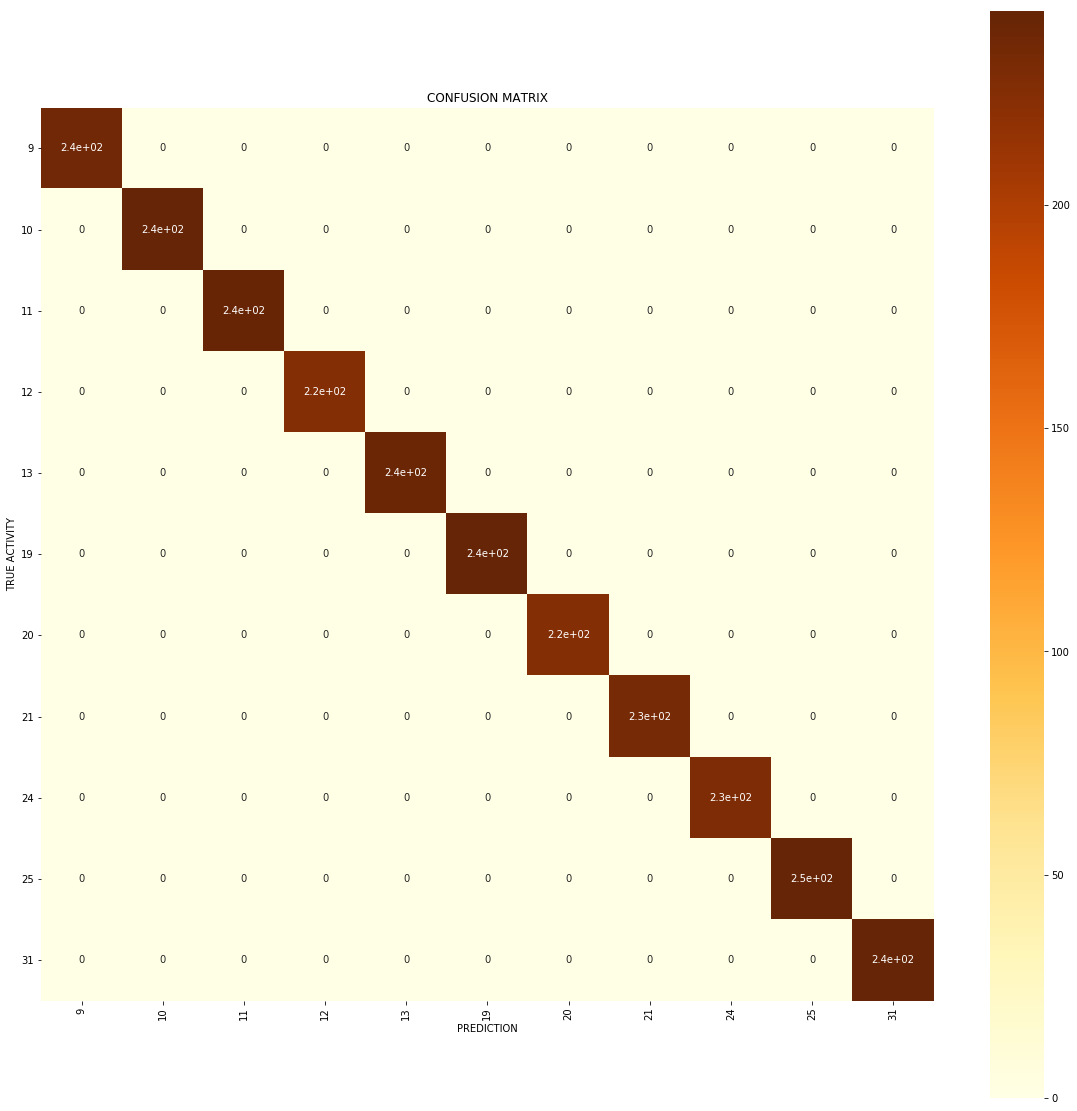

##################################################################################################################################
#####################################################  K-FOLD 4  ################################################################
Train dataset: 
(23512, 1, 128, 40) (23512, 11)
Test dataset: 
(2613, 1, 128, 40) (2613, 11)


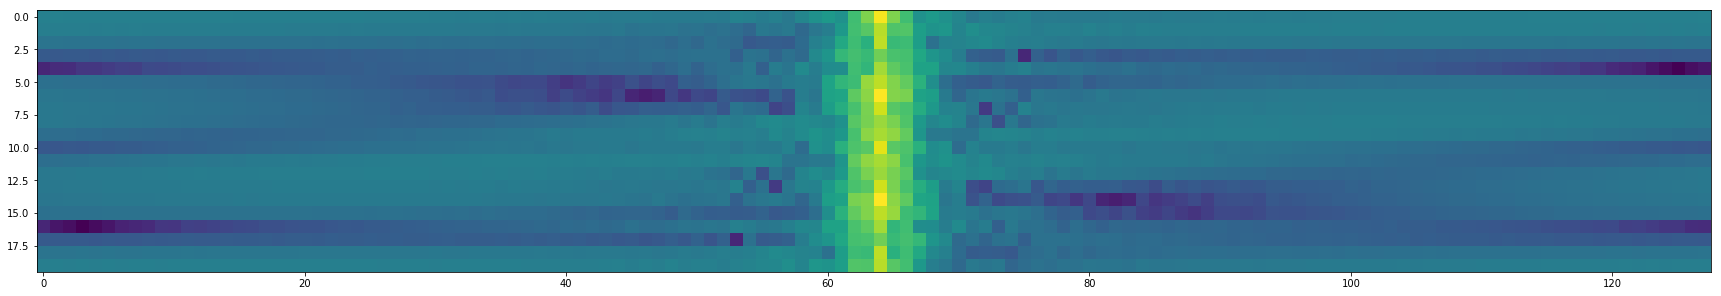

Activity:  13


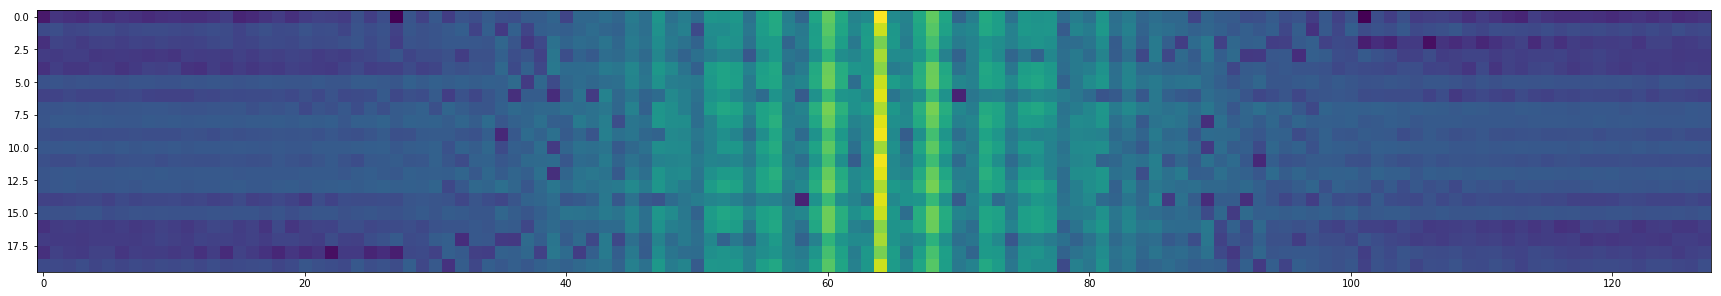

Activity:  25
Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1, 128, 40)]      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 128, 40)       272       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 64, 20)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 16, 64, 20)        64        
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 64, 20)        8224      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 10)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 10240)       

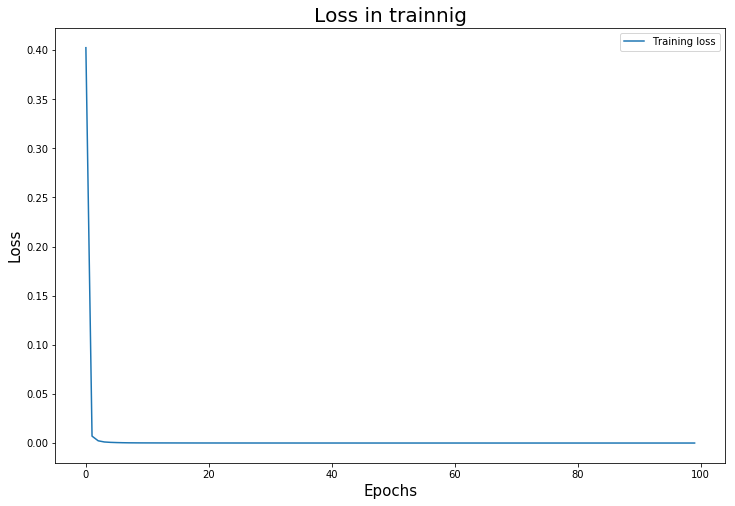

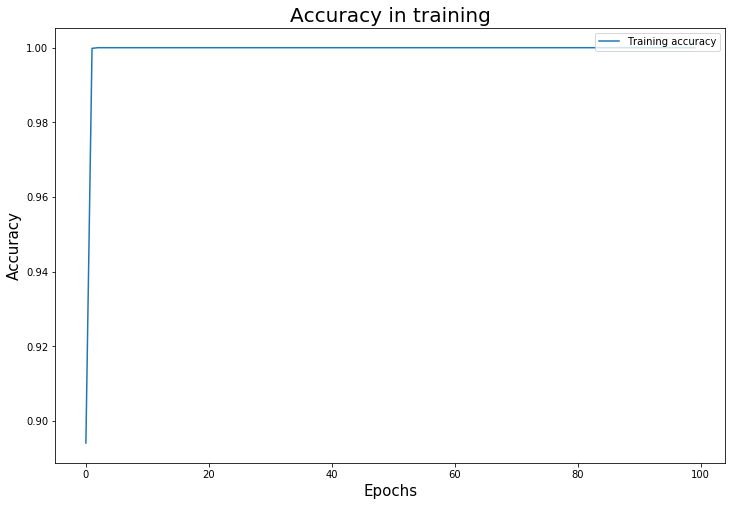

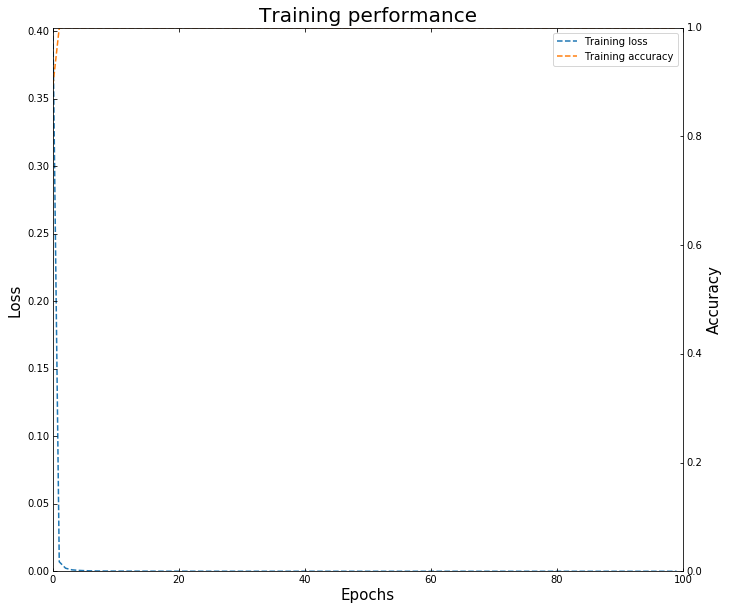

2613/2613 [==============================] - 0s 98us/sample
(2613, 11)
[[ 6 10 10  6  0  7  6  4  9  1  9  9  7  0  6  6  5 10  7  9  1  3  6  8
   0  5  0  0  0  3  6 10  9  3  7  4  7  7  4  0  4  7  9  1  6  1  8  1
   3  8  0 10  3 10  1  6  2  7  8  5  5  5  2  6  5  0  5  9  0  4  0  8
   0  0  4  6  3  7  3 10  2  4  5  3  6  8  4  4  8  3  3  6  4  9  6  5
   9  3  8  2]]
(2613, 1)
[[ 6 10 10  6  0  7  6  4  9  1  9  9  7  0  6  6  5 10  7  9  1  3  6  8
   0  5  0  0  0  3  6 10  9  3  7  4  7  7  4  0  4  7  9  1  6  1  8  1
   3  8  0 10  3 10  1  6  2  7  8  5  5  5  2  6  5  0  5  9  0  4  0  8
   0  0  4  6  3  7  3 10  2  4  5  3  6  8  4  4  8  3  3  6  4  9  6  5
   9  3  8  2]]
2613/2613 [==============================] - 0s 110us/sample - loss: 4.9385e-05 - categorical_accuracy: 1.0000


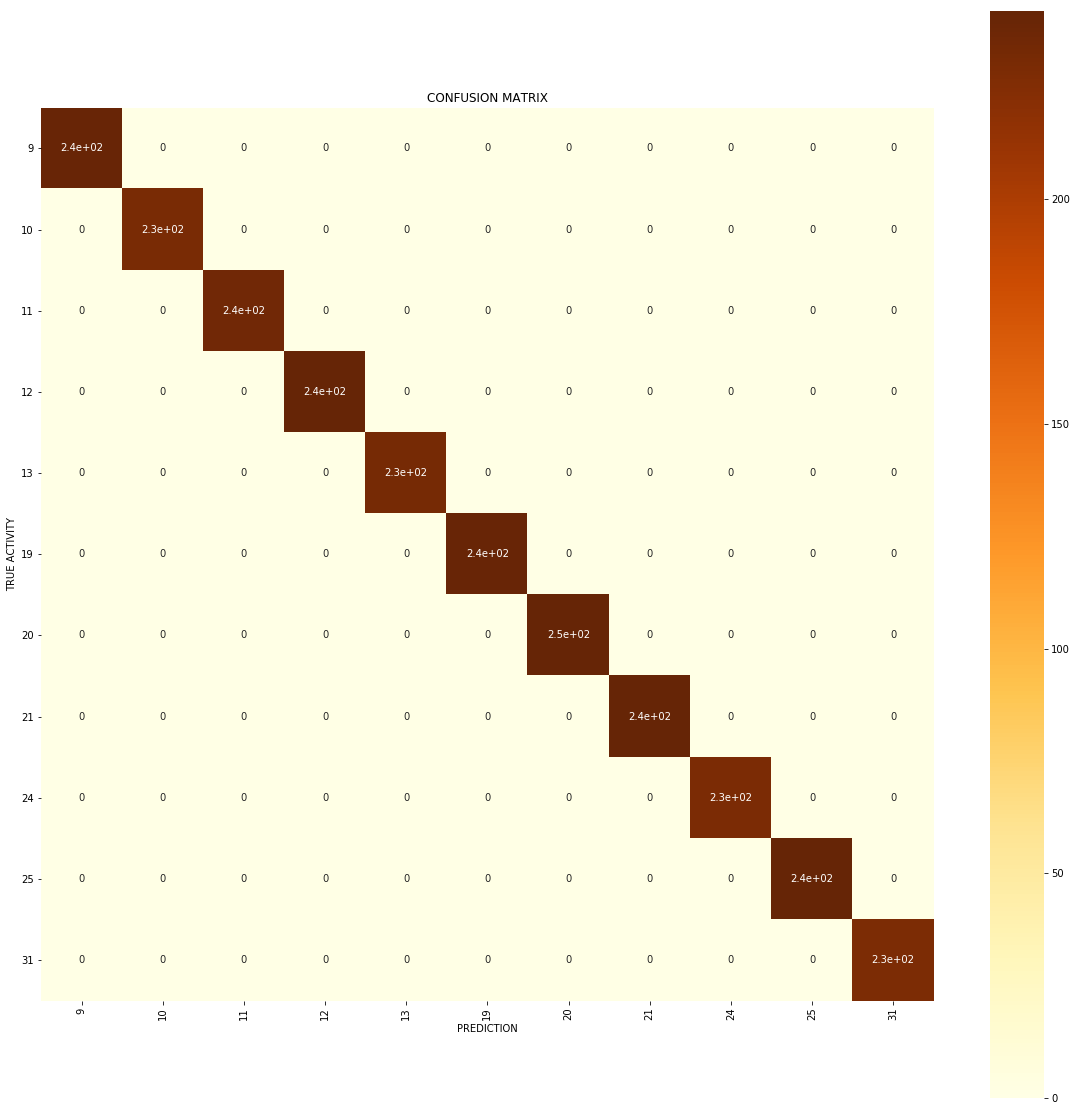

##################################################################################################################################
#####################################################  K-FOLD 5  ################################################################
Train dataset: 
(23512, 1, 128, 40) (23512, 11)
Test dataset: 
(2613, 1, 128, 40) (2613, 11)


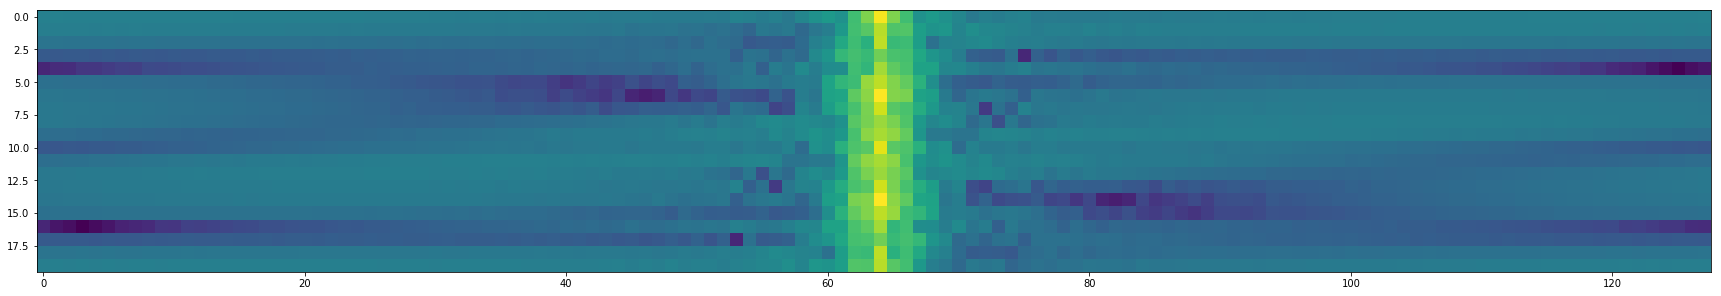

Activity:  13


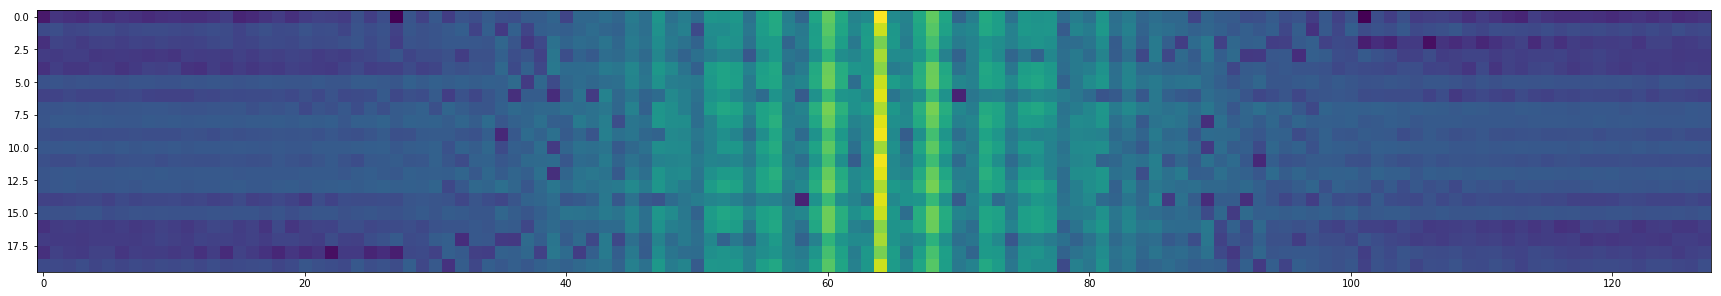

Activity:  25
Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1, 128, 40)]      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 128, 40)       272       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 64, 20)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 64, 20)        64        
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 64, 20)        8224      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 32, 10)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 10240)       

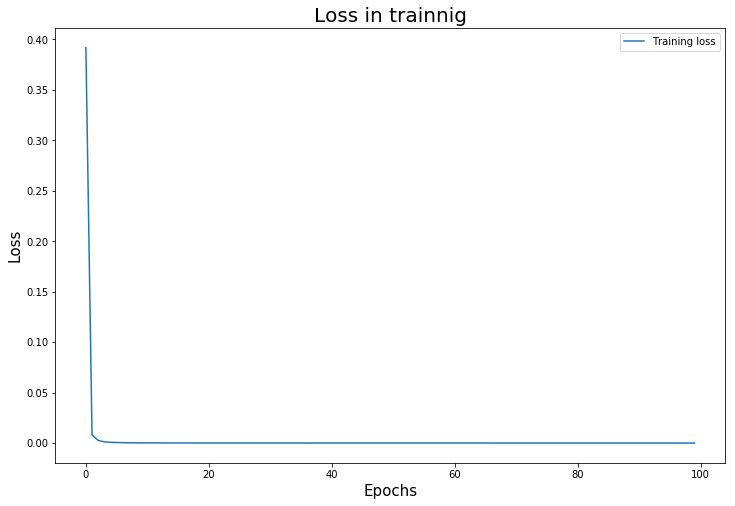

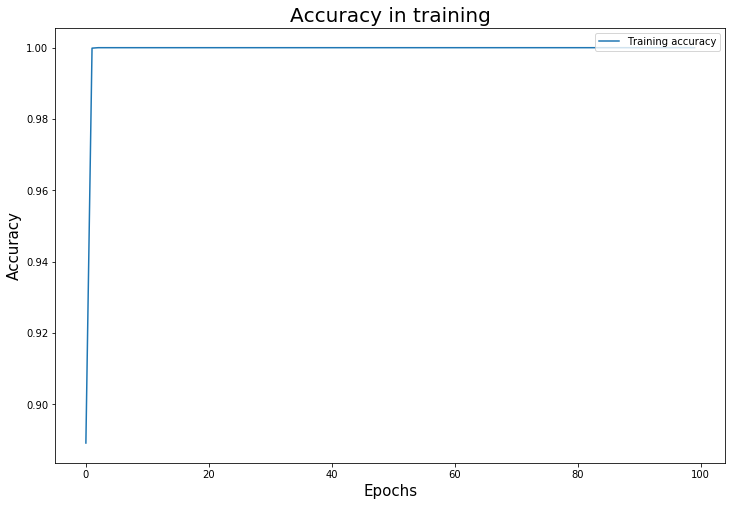

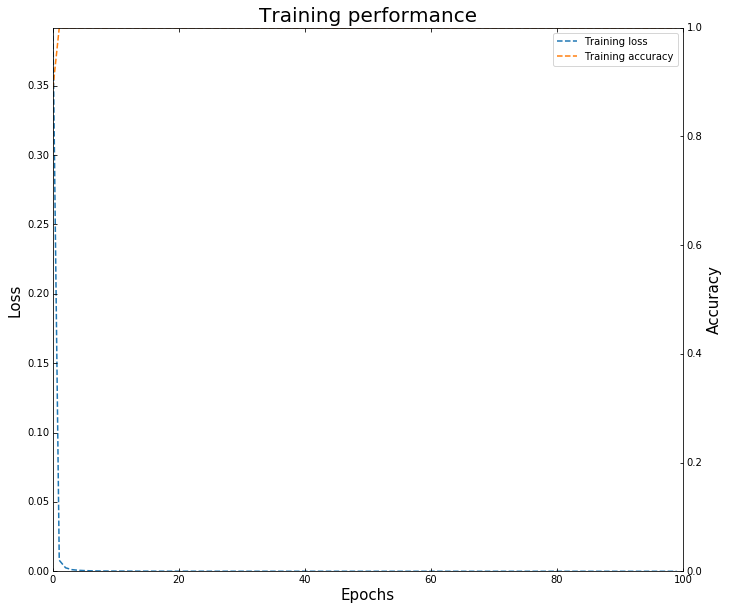

2613/2613 [==============================] - 0s 94us/sample
(2613, 11)
[[ 2  2  3  5  9  0 10  8  8  7  4  3  7  4  8  7  0  0  6  2  8  7  9  0
  10  6 10  8  7  9  4  8  8 10  5  7  4  8  8  0  8  9  2  9  6  1  9 10
   3  1  3 10  9  2  6  6  6  5  5  1  9  6  1  0  2  3  6  2 10  6  9  4
   6  6  7  8  6  1  8  1  0  3  8  5  5  4  0  0  8  4 10  9  3  9 10 10
   0  3  6  6]]
(2613, 1)
[[ 2  2  3  5  9  0 10  8  8  7  4  3  7  4  8  7  0  0  6  2  8  7  9  0
  10  6 10  8  7  9  4  8  8 10  5  7  4  8  8  0  8  9  2  9  6  1  9 10
   3  1  3 10  9  2  6  6  6  5  5  1  9  6  1  0  2  3  6  2 10  6  9  4
   6  6  7  8  6  1  8  1  0  3  8  5  5  4  0  0  8  4 10  9  3  9 10 10
   0  3  6  6]]
2613/2613 [==============================] - 0s 110us/sample - loss: 2.8799e-05 - categorical_accuracy: 1.0000


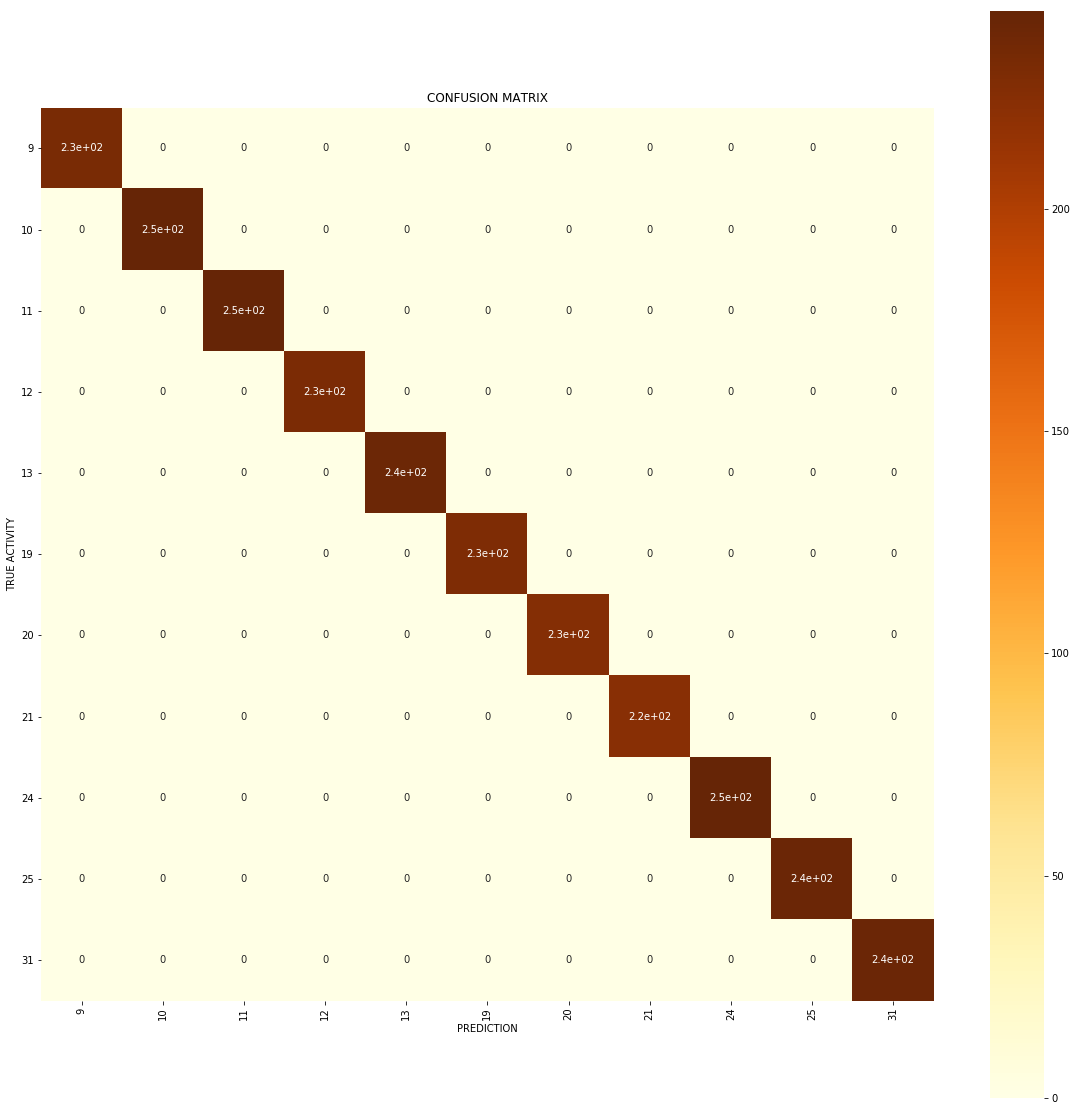

##################################################################################################################################
#####################################################  K-FOLD 6  ################################################################
Train dataset: 
(23513, 1, 128, 40) (23513, 11)
Test dataset: 
(2612, 1, 128, 40) (2612, 11)


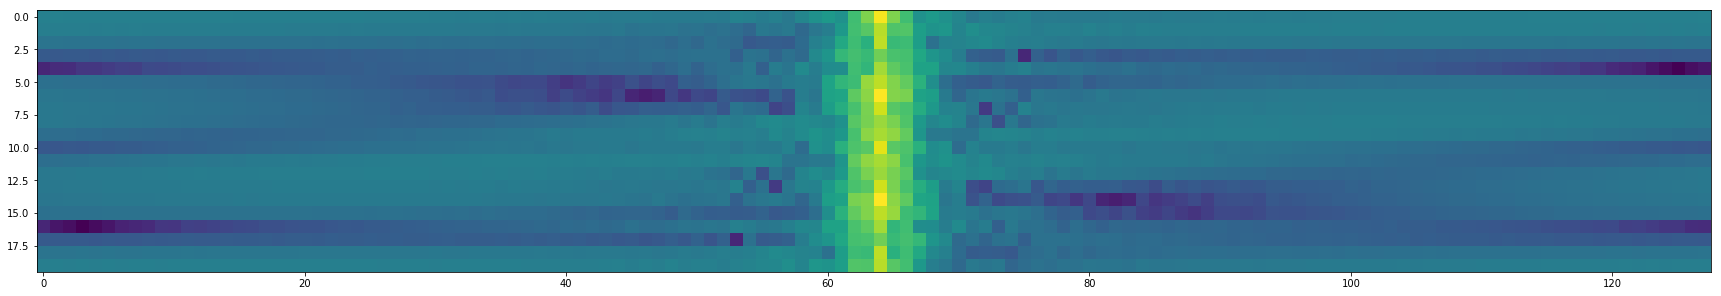

Activity:  13


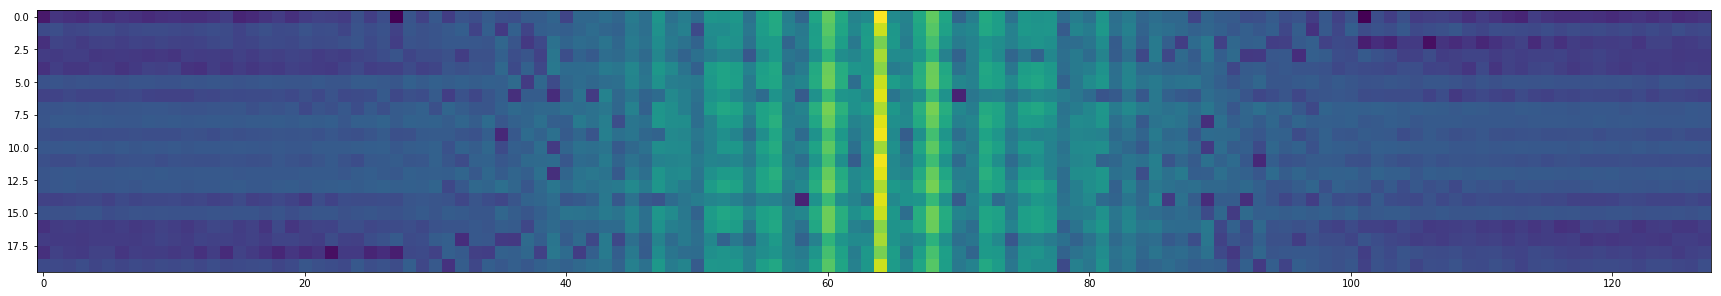

Activity:  25
Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1, 128, 40)]      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 128, 40)       272       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 64, 20)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 16, 64, 20)        64        
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 64, 20)        8224      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 32, 32, 10)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 10240)       

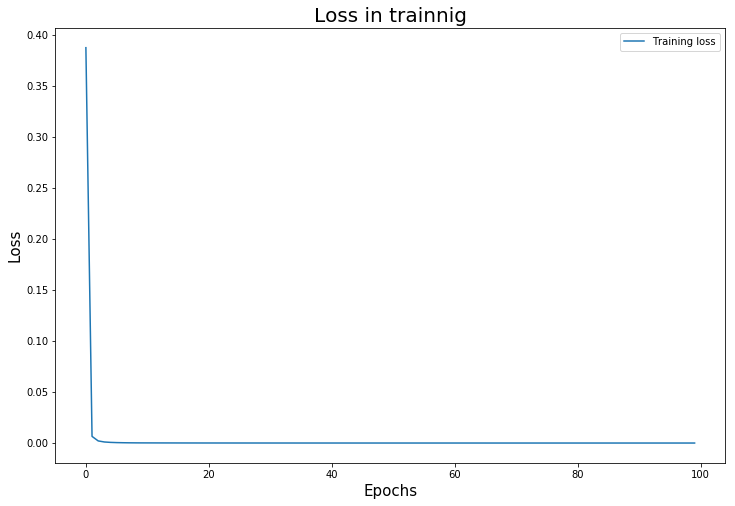

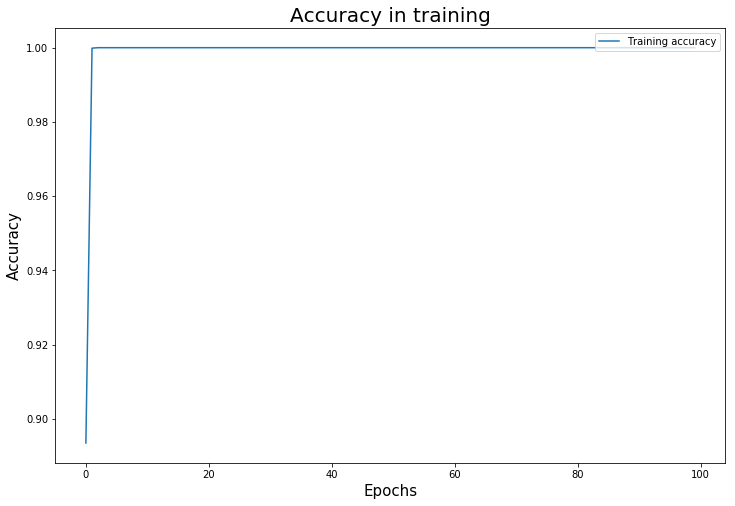

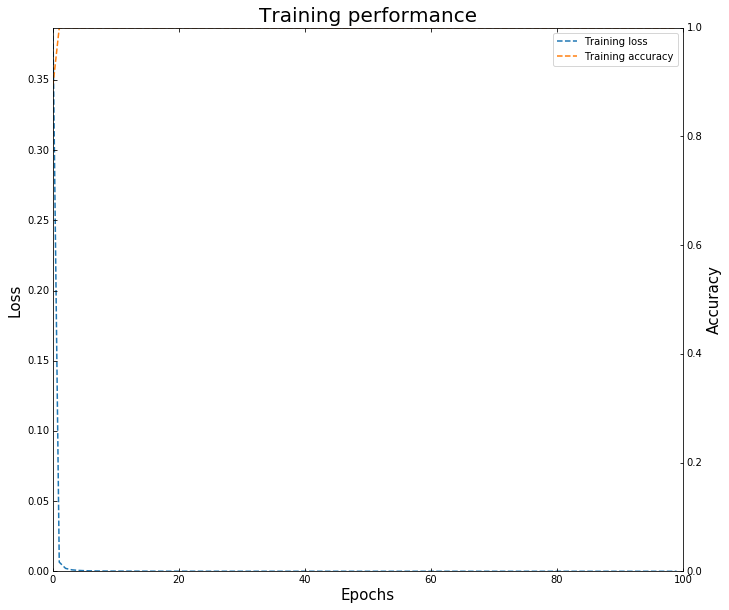

2612/2612 [==============================] - 0s 109us/sample
(2612, 11)
[[ 7  6  9  0  3  1  0  3  9  2  8  7 10  5  9  4  0  7  2  4  6  9  0  6
  10  9  0  9  3  8  1  8  0  2  6  5  2  2  8  6  6  1 10  5  3  5  2  6
   0  4  3  9  3  8  3  8  1  1  4  6  4 10  4  7  8  5  3  1 10  5 10  3
   0  4  6  2  0  6  3  5  3  0  3  2 10  5 10  5 10  1  4  0  8  8  3  8
   9  8  9 10]]
(2612, 1)
[[ 7  6  9  0  3  1  0  3  9  2  8  7 10  5  9  4  0  7  2  4  6  9  0  6
  10  9  0  9  3  8  1  8  0  2  6  5  2  2  8  6  6  1 10  5  3  5  2  6
   0  4  3  9  3  8  3  8  1  1  4  6  4 10  4  7  8  5  3  1 10  5 10  3
   0  4  6  2  0  6  3  5  3  0  3  2 10  5 10  5 10  1  4  0  8  8  3  8
   9  8  9 10]]
2612/2612 [==============================] - 0s 125us/sample - loss: 1.2866e-05 - categorical_accuracy: 1.0000


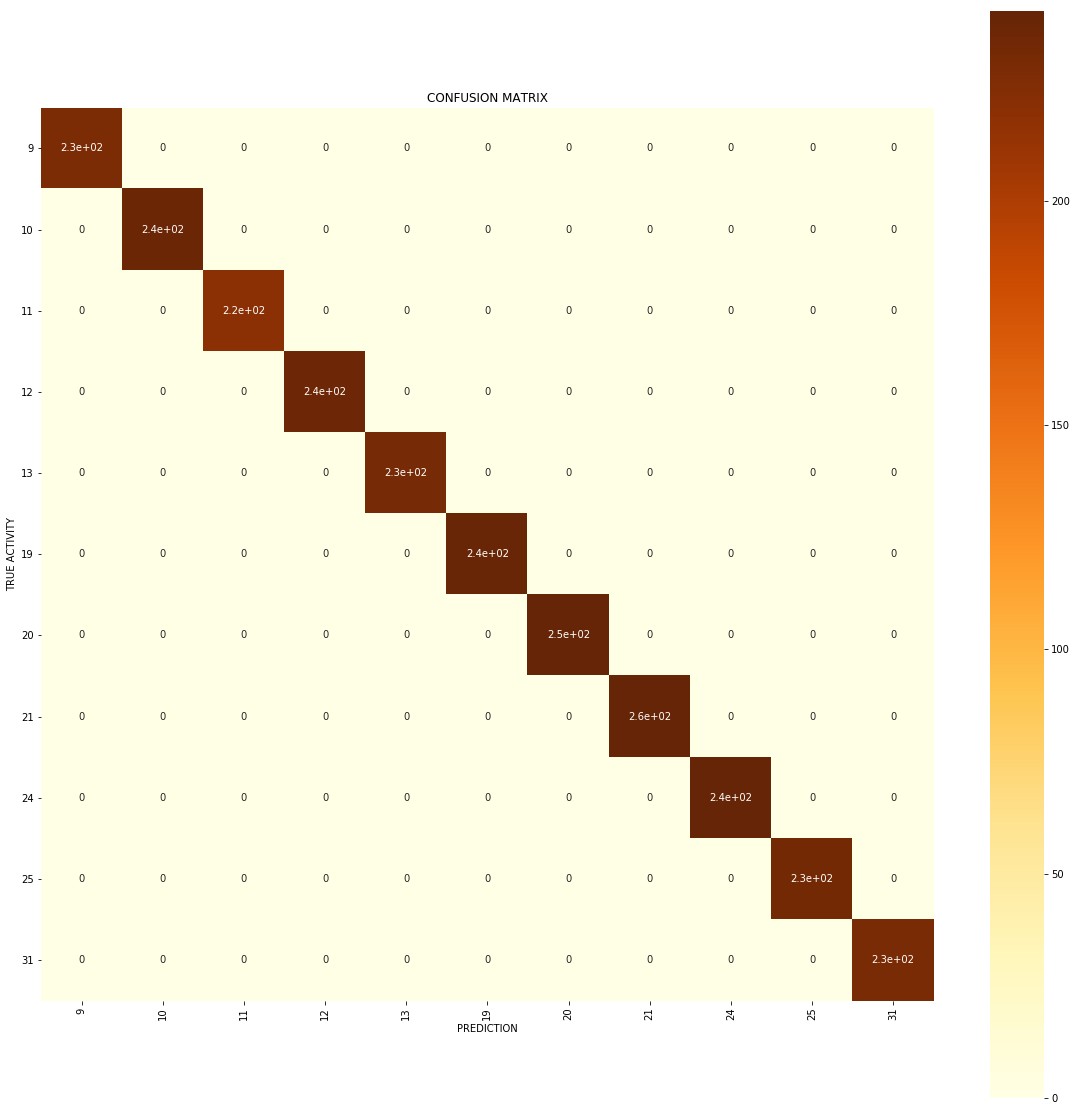

##################################################################################################################################
#####################################################  K-FOLD 7  ################################################################
Train dataset: 
(23513, 1, 128, 40) (23513, 11)
Test dataset: 
(2612, 1, 128, 40) (2612, 11)


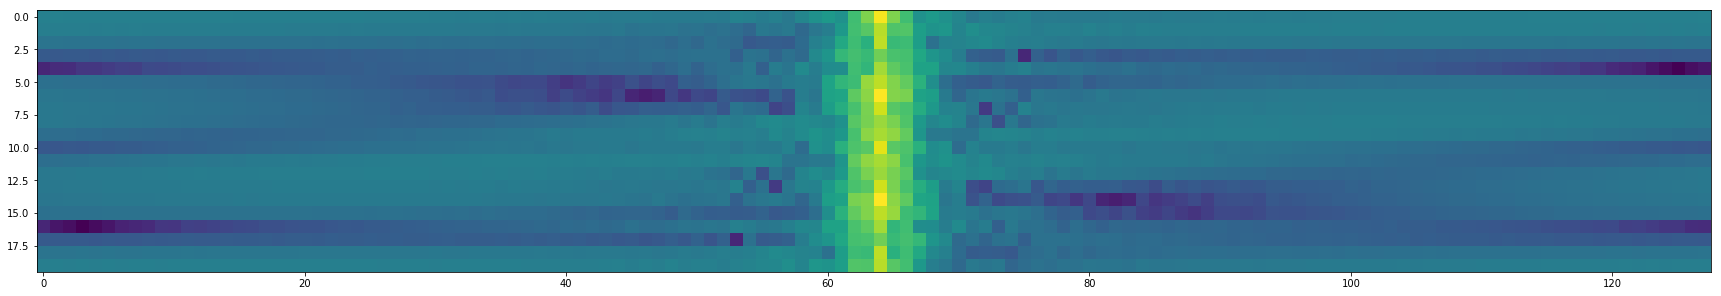

Activity:  13


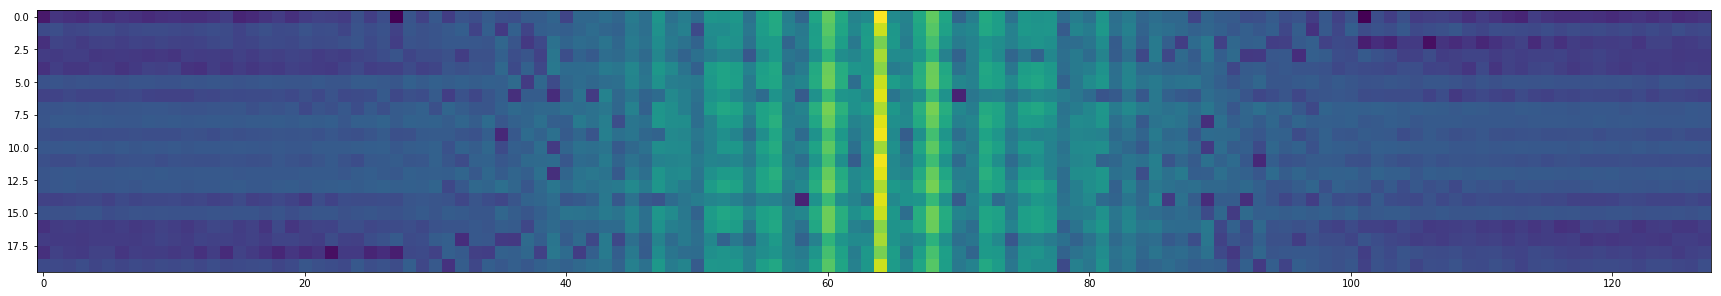

Activity:  25
Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1, 128, 40)]      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 128, 40)       272       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 64, 20)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 64, 20)        64        
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 64, 20)        8224      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 32, 10)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 10240)       

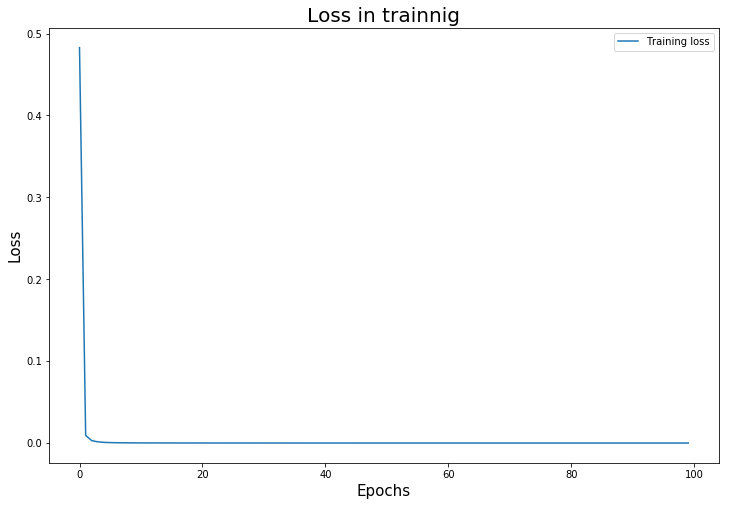

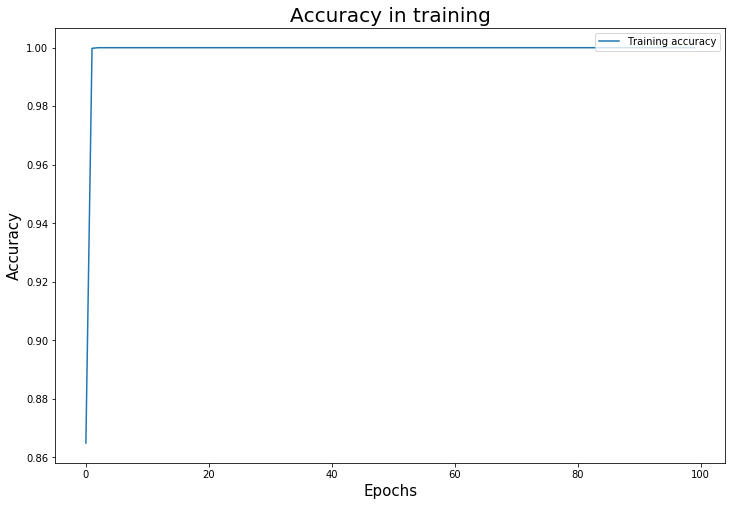

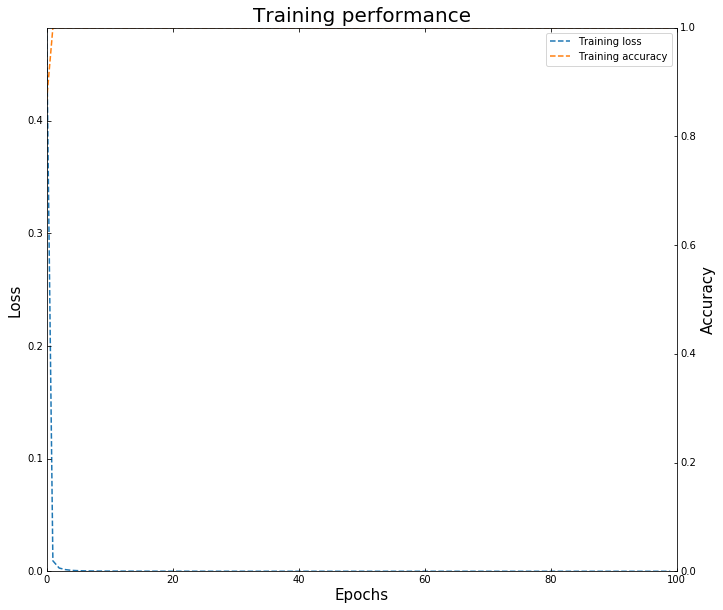

2612/2612 [==============================] - 0s 98us/sample
(2612, 11)
[[ 0  9  3  8 10  8  8  8  9  9  8  4  3  5  2  8 10  4  6  7  5  2  3  2
   6  2  7  3  3  9  9  7 10  1  0  0  5  5  4  9  3  6  0  4  6  0  9  5
   1  4  4  5  2  1  0  2  8 10  5  8 10 10  2 10  7 10  4  3  2  3  9  2
   3  0  9  8 10  1  1  6  1  4  1  5  3  9  4  1  2  2  8  8  5  8  1  4
  10  5 10 10]]
(2612, 1)
[[ 0  9  3  8 10  8  8  8  9  9  8  4  3  5  2  8 10  4  6  7  5  2  3  2
   6  2  7  3  3  9  9  7 10  1  0  0  5  5  4  9  3  6  0  4  6  0  9  5
   1  4  4  5  2  1  0  2  8 10  5  8 10 10  2 10  7 10  4  3  2  3  9  2
   3  0  9  8 10  1  1  6  1  4  1  5  3  9  4  1  2  2  8  8  5  8  1  4
  10  5 10 10]]
2612/2612 [==============================] - 0s 113us/sample - loss: 2.2783e-05 - categorical_accuracy: 1.0000


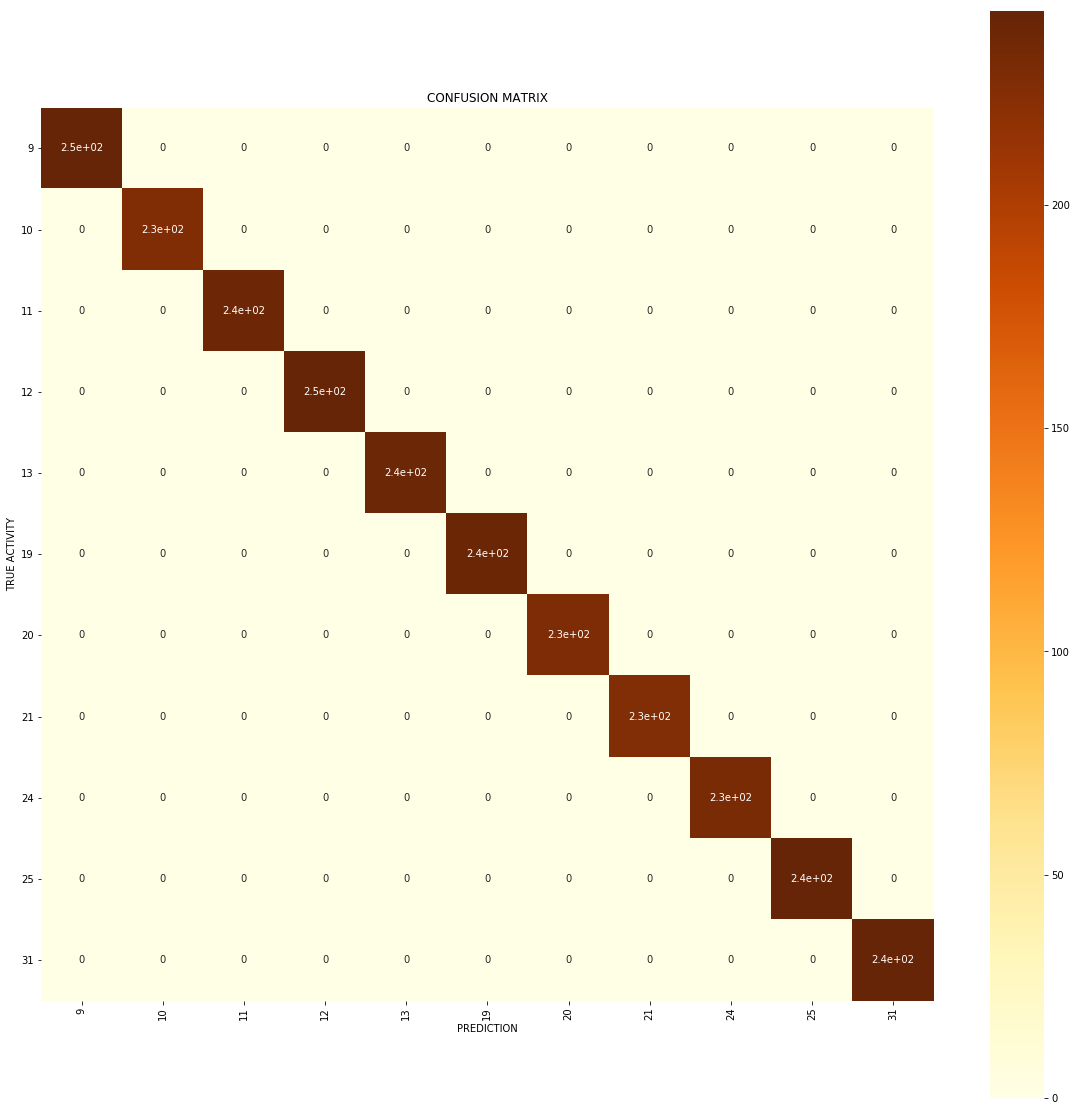

##################################################################################################################################
#####################################################  K-FOLD 8  ################################################################
Train dataset: 
(23513, 1, 128, 40) (23513, 11)
Test dataset: 
(2612, 1, 128, 40) (2612, 11)


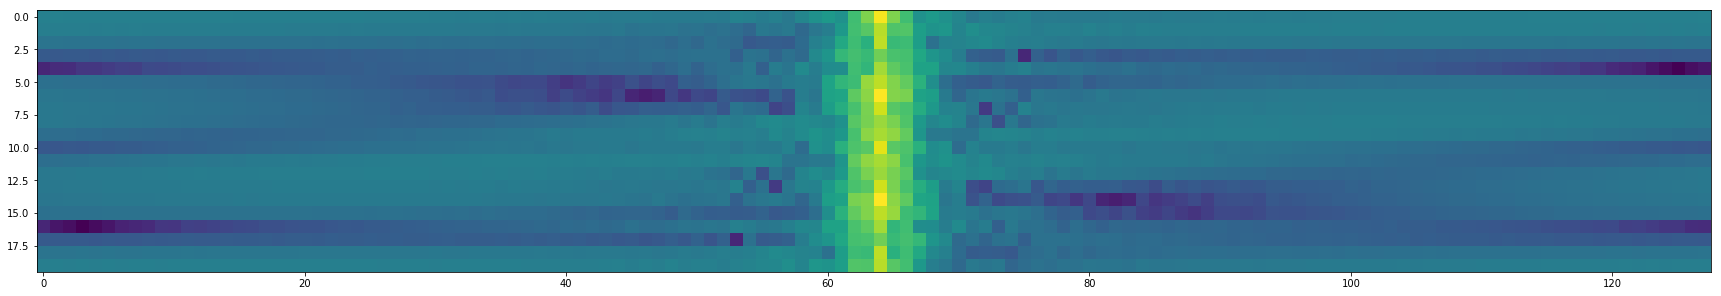

Activity:  13


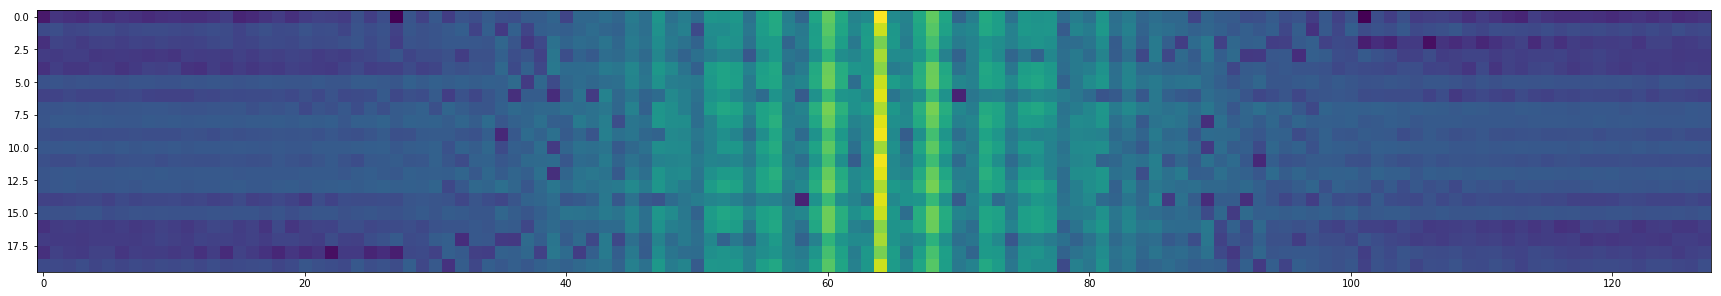

Activity:  25
Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1, 128, 40)]      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 128, 40)       272       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 16, 64, 20)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 16, 64, 20)        64        
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 64, 20)        8224      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 32, 32, 10)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 10240)       

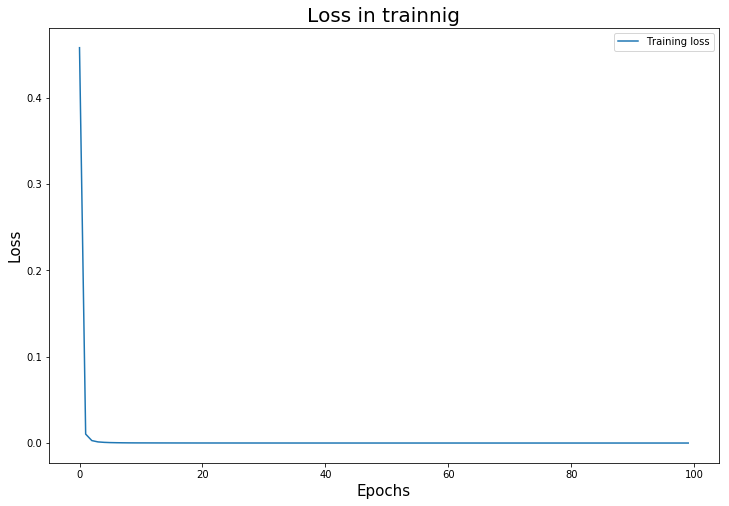

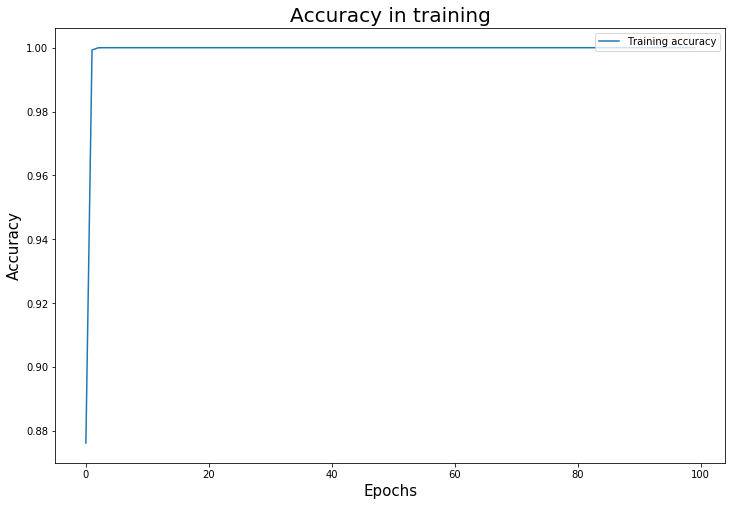

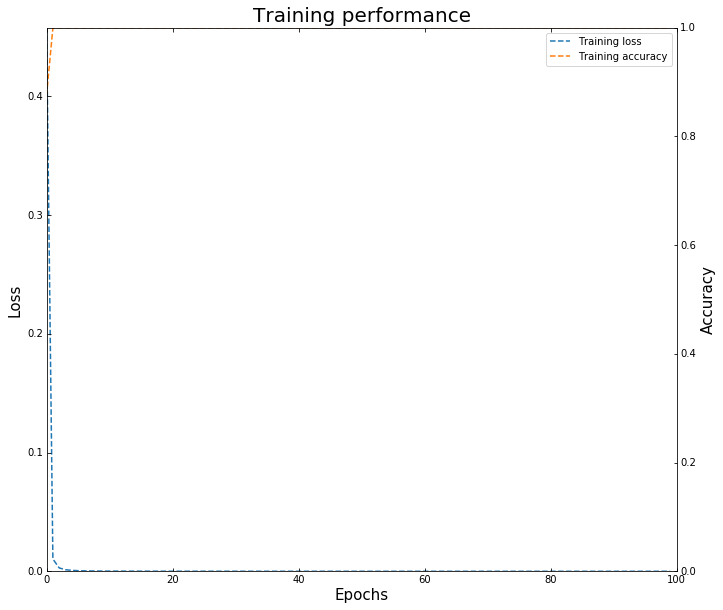

2612/2612 [==============================] - 0s 104us/sample
(2612, 11)
[[ 7  2  4  5  8  4  4  9 10  7  4  4  3  0  8  9  2  7  8  1  2  5  0  5
   0  1  5  6  5  3  6  1  2  7 10  1  5  0  7  9  6  6  8  5  6  7  6  4
   4  2  1  3  5  0  8  2  9 10  9  5  5  1 10  7  2  7  7  9  0  1  4  6
   8  6  4  3  4  2  6  8  2  4 10  4 10 10 10  0  4  1  5 10  4  0 10  5
   3  6 10  2]]
(2612, 1)
[[ 7  2  4  5  8  4  4  9 10  7  4  4  3  0  8  9  2  7  8  1  2  5  0  5
   0  1  5  6  5  3  6  1  2  7 10  1  5  0  7  9  6  6  8  5  6  7  6  4
   4  2  1  3  5  0  8  2  9 10  9  5  5  1 10  7  2  7  7  9  0  1  4  6
   8  6  4  3  4  2  6  8  2  4 10  4 10 10 10  0  4  1  5 10  4  0 10  5
   3  6 10  2]]
2612/2612 [==============================] - 0s 115us/sample - loss: 2.4193e-04 - categorical_accuracy: 1.0000


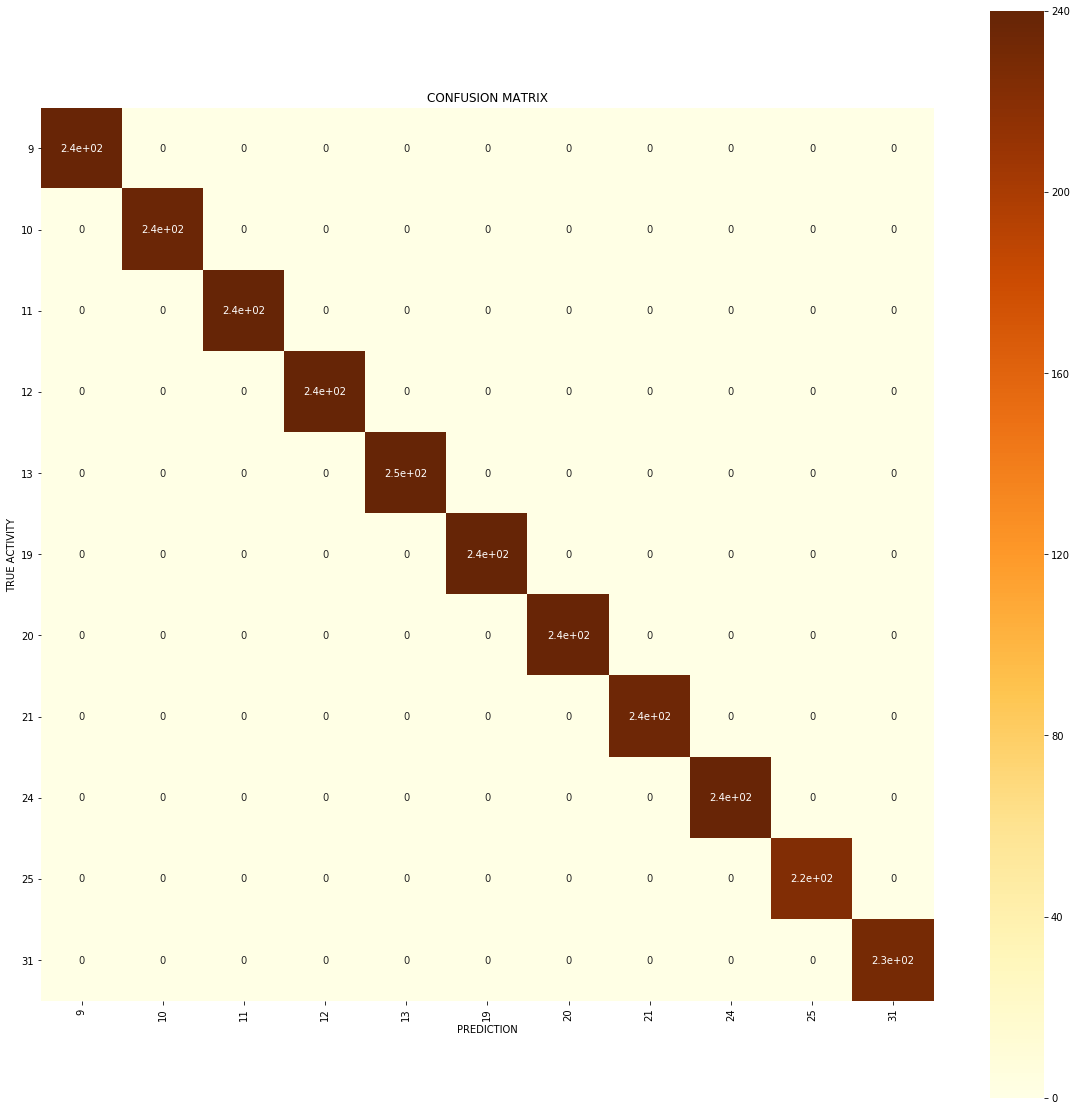

##################################################################################################################################
#####################################################  K-FOLD 9  ################################################################
Train dataset: 
(23513, 1, 128, 40) (23513, 11)
Test dataset: 
(2612, 1, 128, 40) (2612, 11)


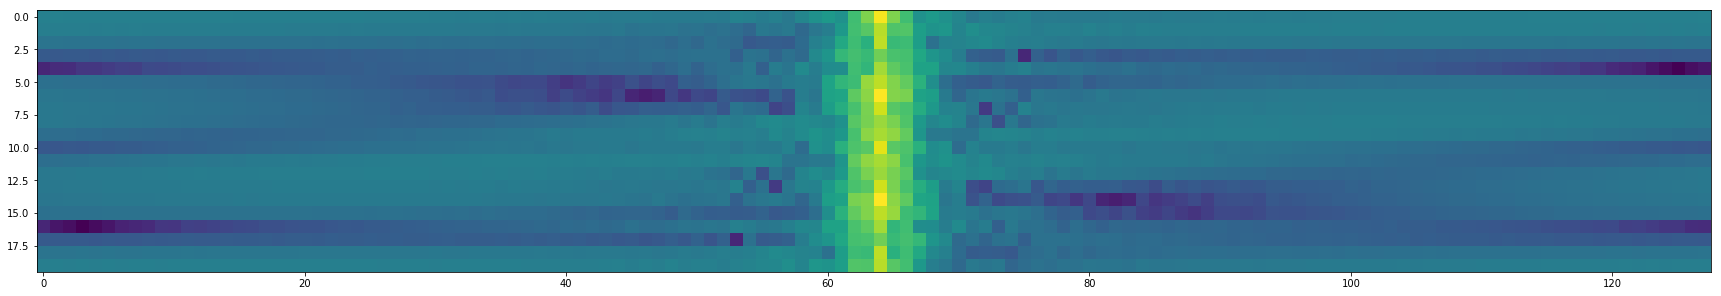

Activity:  13


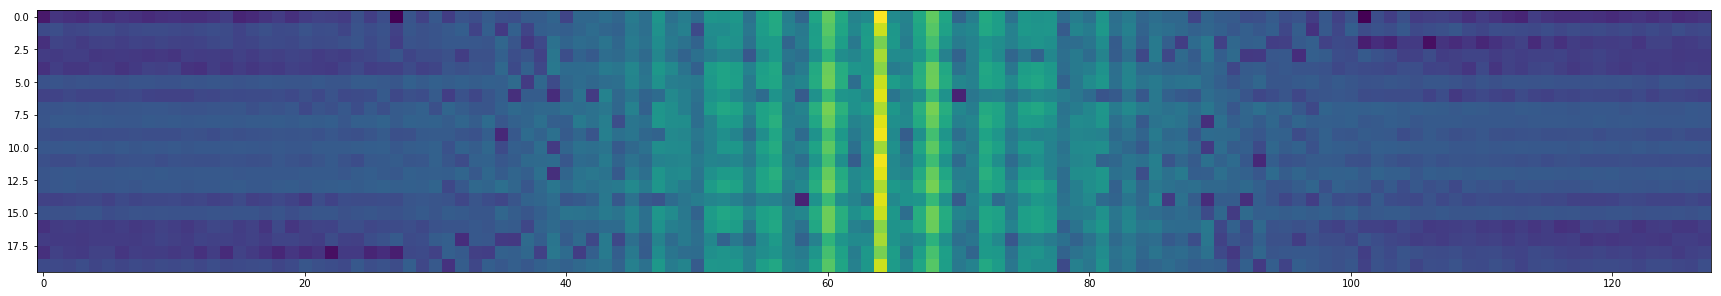

Activity:  25
Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1, 128, 40)]      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 128, 40)       272       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 16, 64, 20)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 16, 64, 20)        64        
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 64, 20)        8224      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 32, 32, 10)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 10240)       

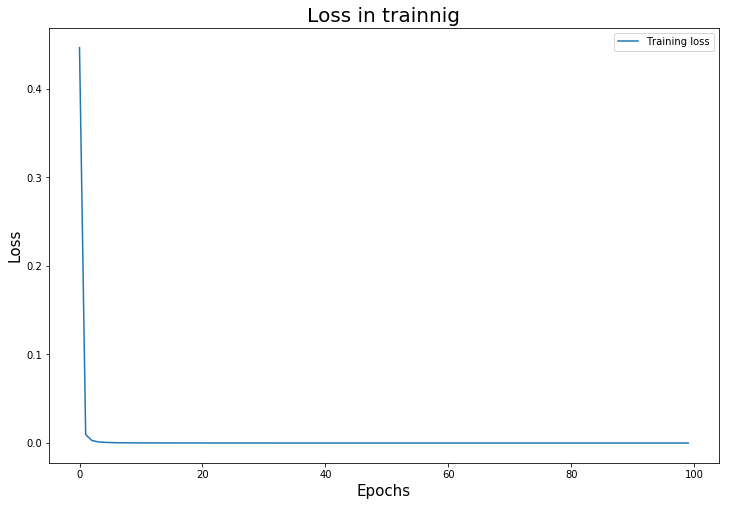

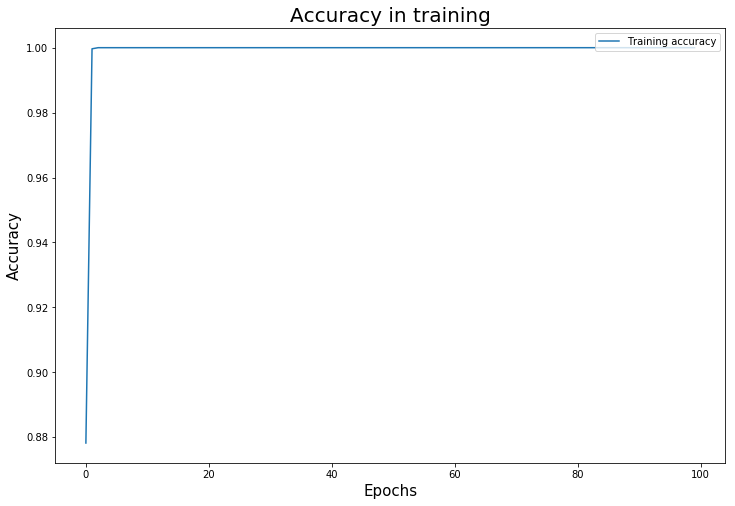

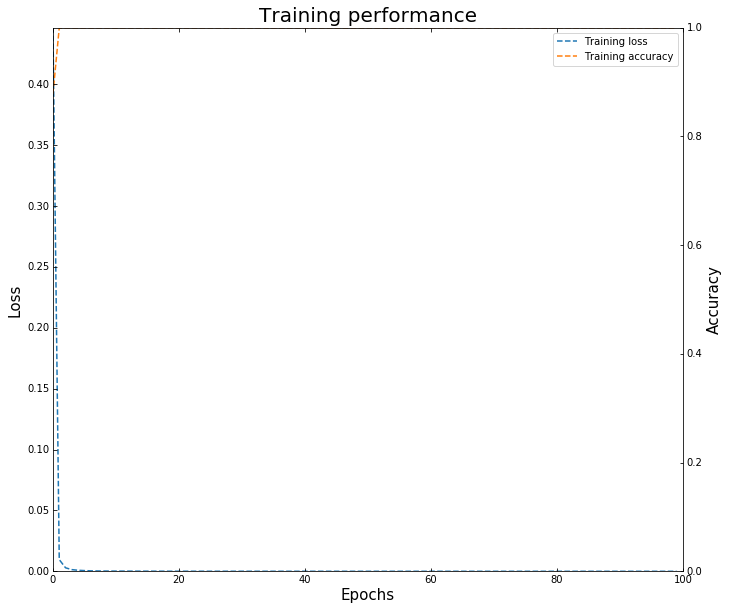

2612/2612 [==============================] - 0s 109us/sample
(2612, 11)
[[ 9  8  4 10  0  6  4  4 10  9  4 10 10  5  8  4  5  4  4  0  8  8  0  7
   9  7  3 10  0  3  0  2  9  1  0  5  8  4  8 10  5  0  0  2  2  6  3  5
   2  2  1  0  3  6  2  1  5  1  5  6  0  4  9  9  7  9  2  8  9  8  5  3
   0  3  1  2  6  8  2  4 10 10  7  7  8  2  3  6  2  8  0  8  3  3  9  8
   6  1  4 10]]
(2612, 1)
[[ 9  8  4 10  0  6  4  4 10  9  4 10 10  5  8  4  5  4  4  0  8  8  0  7
   9  7  3 10  0  3  0  2  9  1  0  5  8  4  8 10  5  0  0  2  2  6  3  5
   2  2  1  0  3  6  2  1  5  1  5  6  0  4  9  9  7  9  2  8  9  8  5  3
   0  3  1  2  6  8  2  4 10 10  7  7  8  2  3  6  2  8  0  8  3  3  9  8
   6  1  4 10]]
2612/2612 [==============================] - 0s 125us/sample - loss: 0.0027 - categorical_accuracy: 0.9996


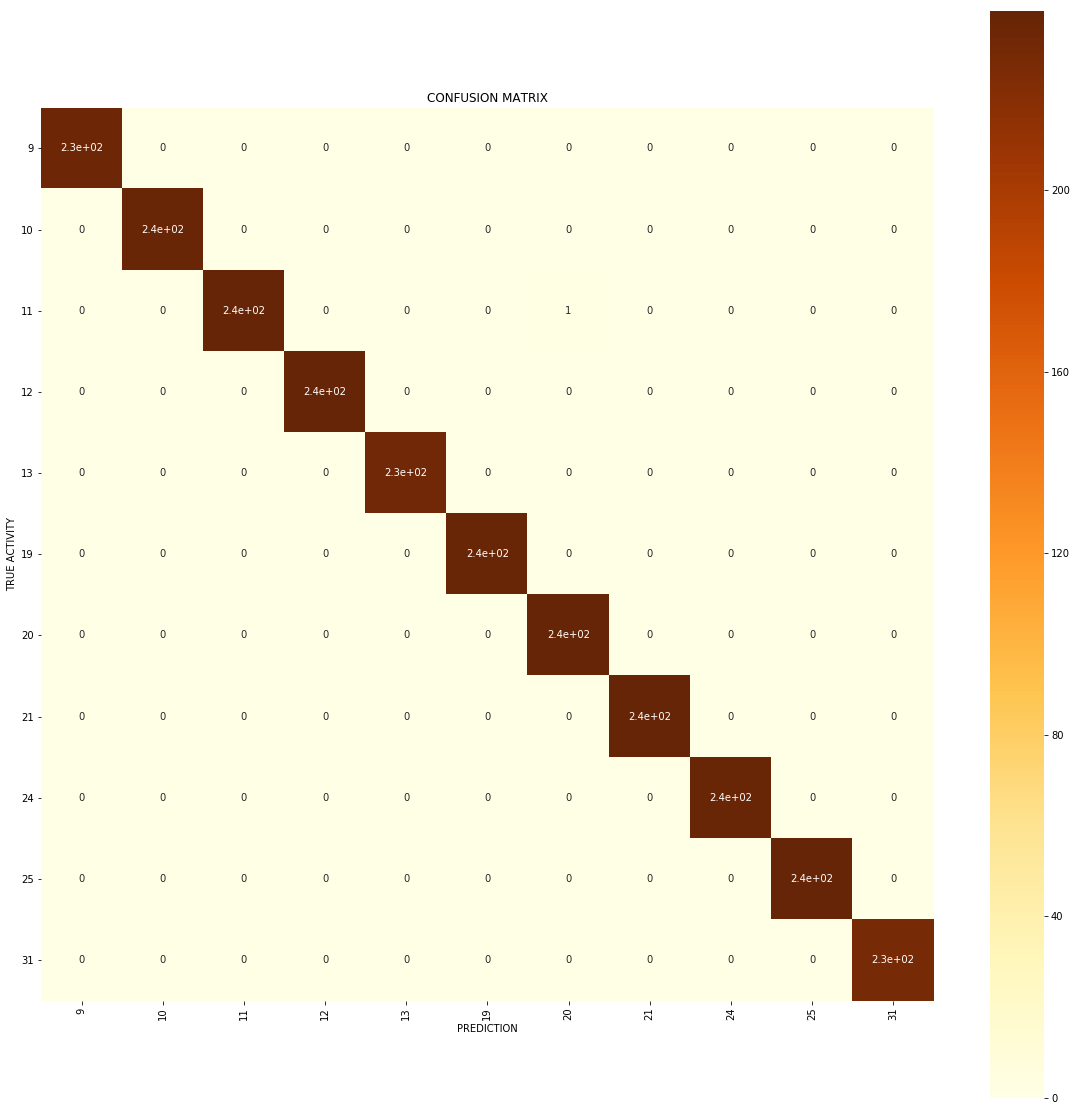

##################################################################################################################################
#####################################################  K-FOLD 10  ################################################################
Train dataset: 
(23513, 1, 128, 40) (23513, 11)
Test dataset: 
(2612, 1, 128, 40) (2612, 11)


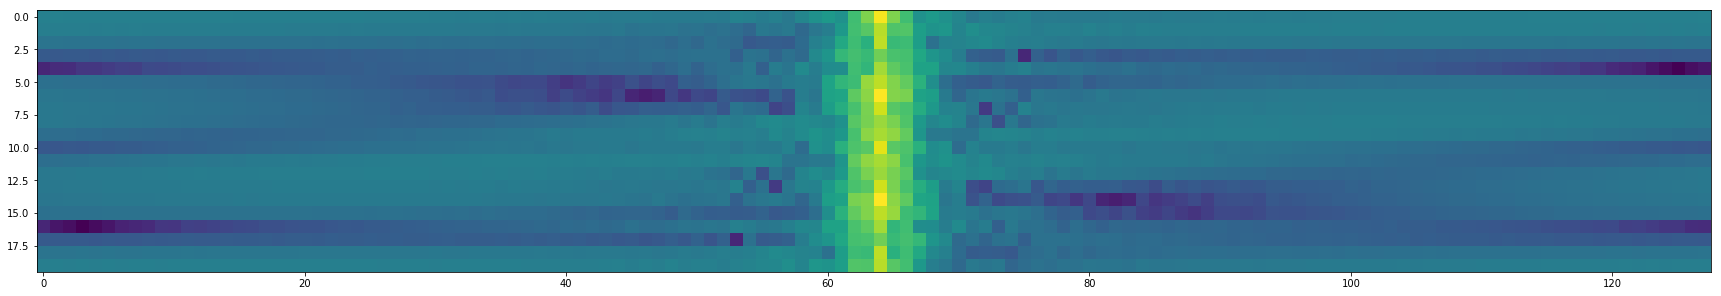

Activity:  13


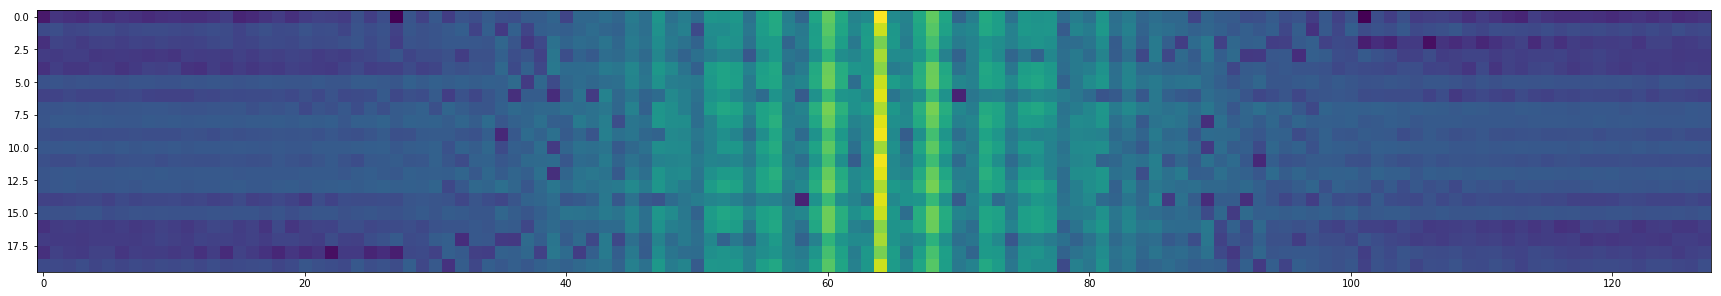

Activity:  25
Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1, 128, 40)]      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 16, 128, 40)       272       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 16, 64, 20)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 16, 64, 20)        64        
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 64, 20)        8224      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 32, 32, 10)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 10240)       

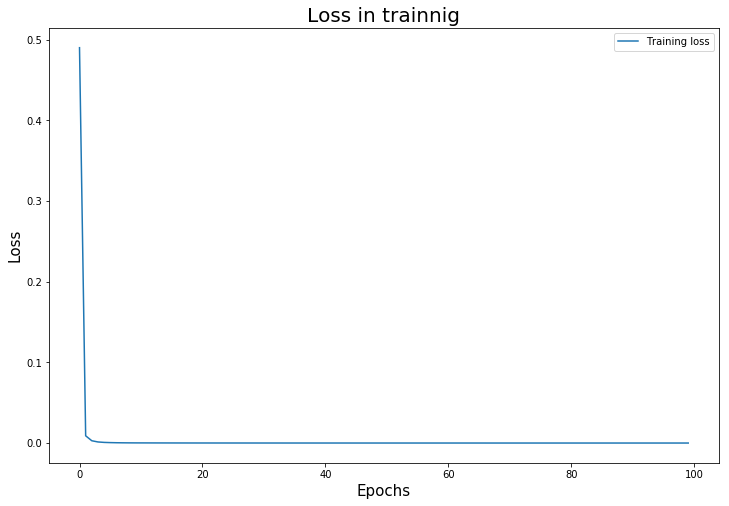

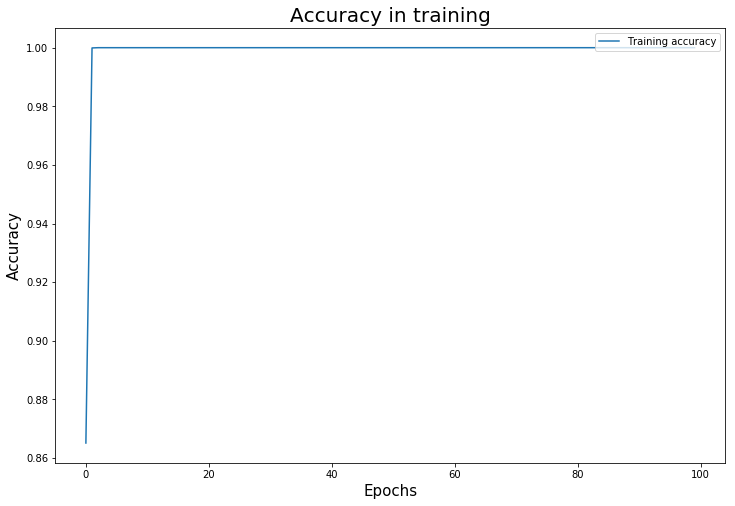

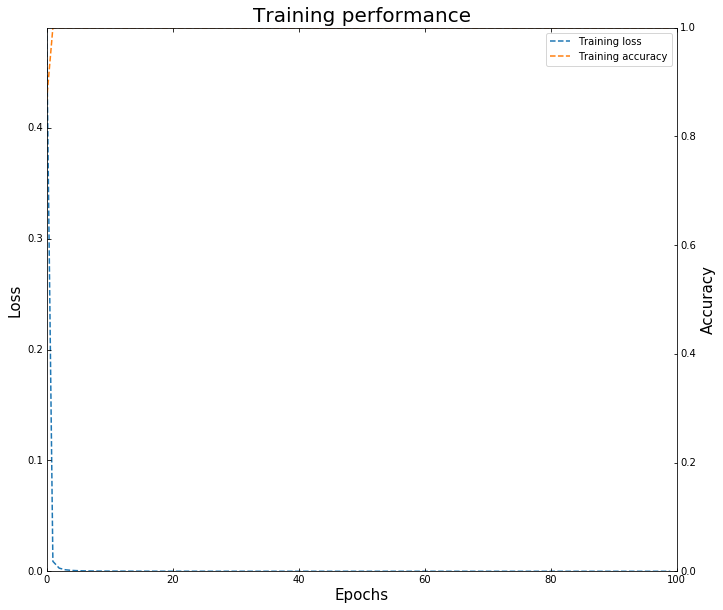

2612/2612 [==============================] - 0s 114us/sample
(2612, 11)
[[ 6  1  3  9  4 10  5  1  4  1  1  8  0 10  3  9  1  8  9  6  1  2  8  1
   6  0  8  2  2 10  1  4  1  4  2  8  5  4  9  5  1 10  5  8  4  7  4  3
   6  8  2  4  7  8  1  5  1 10  7  7  0  8  7  9  7  3  4  6  4  4  3  7
   3  9  0  9  5  8  2  1  2 10 10  1  3  6  9 10 10  1  0  9  8 10 10  2
  10  2  8  6]]
(2612, 1)
[[ 6  1  3  9  4 10  5  1  4  1  1  8  0 10  3  9  1  8  9  6  1  2  8  1
   6  0  8  2  2 10  1  4  1  4  2  8  5  4  9  5  1 10  5  8  4  7  4  3
   6  8  2  4  7  8  1  5  1 10  7  7  0  8  7  9  7  3  4  6  4  4  3  7
   3  9  0  9  5  8  2  1  2 10 10  1  3  6  9 10 10  1  0  9  8 10 10  2
  10  2  8  6]]
2612/2612 [==============================] - 0s 129us/sample - loss: 0.1859 - categorical_accuracy: 0.9315


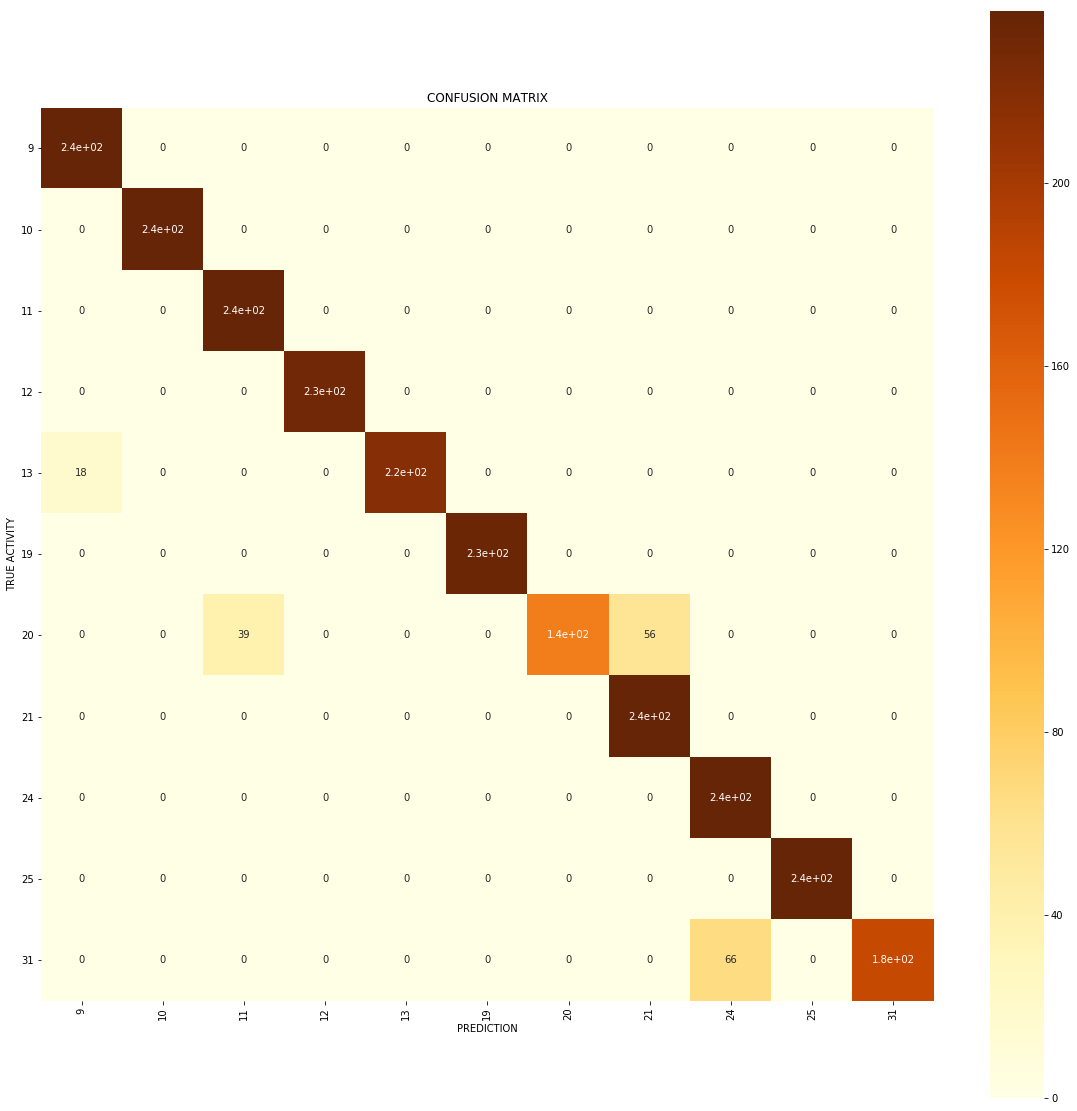

In [12]:
# Ejecución del K-Fold
accuracies = []
for i in range(10):
    if(i<10):
        kfold='0'+str(i)
    else:
        kfold=str(i)
    print('##################################################################################################################################')
    print('#####################################################  K-FOLD %d  ################################################################'%(i+1))
    
    subjects = ['01', '02', '03', '05', '08', '09', '10', '11', '13', '14', '16', '17']
    
    ##  GENERACIÓN DATASET
    # Se leen los datos ya preprocesados previamente y guardados en .npy
    tr_seg = np.concatenate((np.load('./augment_norm/subject_'+subjects[0]+'_seg.npy'),np.load('./augment_norm/subject_'+subjects[1]+'_seg.npy'),np.load('./augment_norm/subject_'+subjects[2]+'_seg.npy'),np.load('./augment_norm/subject_'+subjects[3]+'_seg.npy'),
                             np.load('./augment_norm/subject_'+subjects[4]+'_seg.npy'),np.load('./augment_norm/subject_'+subjects[5]+'_seg.npy'),np.load('./augment_norm/subject_'+subjects[6]+'_seg.npy'),np.load('./augment_norm/subject_'+subjects[7]+'_seg.npy'),
                             np.load('./augment_norm/subject_'+subjects[8]+'_seg.npy'),np.load('./augment_norm/subject_'+subjects[9]+'_seg.npy'),np.load('./augment_norm/subject_'+subjects[10]+'_seg.npy')))

    tr_lab = np.concatenate((np.load('./augment_norm/subject_'+subjects[0]+'_lab.npy'),np.load('./augment_norm/subject_'+subjects[1]+'_lab.npy'),np.load('./augment_norm/subject_'+subjects[2]+'_lab.npy'),np.load('./augment_norm/subject_'+subjects[3]+'_lab.npy'),
                             np.load('./augment_norm/subject_'+subjects[4]+'_lab.npy'),np.load('./augment_norm/subject_'+subjects[5]+'_lab.npy'),np.load('./augment_norm/subject_'+subjects[6]+'_lab.npy'),np.load('./augment_norm/subject_'+subjects[7]+'_lab.npy'),
                             np.load('./augment_norm/subject_'+subjects[8]+'_lab.npy'),np.load('./augment_norm/subject_'+subjects[9]+'_lab.npy'),np.load('./augment_norm/subject_'+subjects[10]+'_lab.npy')))
    
    limit = 40 # Nº de features a utilizar
    tr_seg = tr_seg[:,:,:,:limit]
    ####################################################################################################################
    ## SHUFFLE DE DATOS
    np.random.seed(235)
    tr_seg = np.reshape(tr_seg[np.random.shuffle(np.arange(0,tr_seg.shape[0]))], (size,1,128,limit))
    tr_lab = np.reshape(tr_lab[np.random.shuffle(np.arange(0,tr_seg.shape[0]))], (size,11))
    
    ts_seg = tr_seg[S_test[i]]
    ts_lab = tr_lab[S_test[i]]
    
    tr_seg = tr_seg[S_train[i]]
    tr_lab = tr_lab[S_train[i]]
    
    print('Train dataset: ')
    print(tr_seg.shape, tr_lab.shape)
    print('Test dataset: ')
    print(ts_seg.shape, ts_lab.shape)
    ####################################################################################################################
    ## VISTA DE DFT-2D
    plt.figure(figsize=(30,30))
    plt.imshow(np.log(np.abs(np.fft.fftshift(tr_seg[0,0,:,20:40].T))**2))
    plt.show()
    print('Activity: ',activities[np.argmax(tr_lab[0])])

    plt.figure(figsize=(30,30))
    plt.imshow(np.log(np.fft.fftshift(tr_seg[10,0,:,20:40].T)**2))
    plt.show()
    print('Activity: ',activities[np.argmax(tr_lab[10])])
    ####################################################################################################################
    ## RED
    # Capa de entrada
    quat_input = keras.Input(shape=(n_channels, n_time_steps, n_columns), name='input_layer')

    # Capas convolucionales
    conv_1 = keras.layers.Conv2D(16, kernel_size=4,padding='same',activation='relu', data_format = 'channels_first')(quat_input)
    max_1 = keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='same', data_format = 'channels_first')(conv_1)
    bn_1 = keras.layers.BatchNormalization(axis=1)(max_1)
    conv_2 = keras.layers.Conv2D(32,kernel_size=4, padding='same',activation='relu', data_format = 'channels_first')(bn_1)
    max_2 = keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='same', data_format = 'channels_first')(conv_2)

    # Reducción de dimensiones
    conv_flat = keras.layers.Flatten()(max_2)

    # Capa de salida: una salida por cada actividad (clase)
    multiclass_output = keras.layers.Dense(n_classes, activation='softmax',name='activity_class')(conv_flat)
    
    # Creamos la estrcutura que contendrá a nuestro modelo
    model = keras.Model(inputs=quat_input, outputs=[multiclass_output],name='cnn')

    # Compilamos el modelo
    model.compile(optimizer=keras.optimizers.Adam(lr=learning_rate),
                  loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    # Lo mostramos
    print(model.summary())
    ####################################################################################################################
    ## TRAIN
    history = model.fit(tr_seg,
                        tr_lab,
                        epochs = epochs,
                        steps_per_epoch = None,
                        verbose = 1,
                        batch_size = batch_size,
                        callbacks = callbacks_list)
    # Guardamos el modelo entrenado
    model.save('./000_1_AUGNORMFFT_RP/CNN_'+kfold+'.h5')
    
    # Visualización de la evolución del entrenamiento
    plot_curves(model, 'categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss', kfold)
    ####################################################################################################################
    ## TEST
    predictions = model.predict(ts_seg, batch_size = batch_size, verbose = 1)
    
    print(predictions.shape)
    
    y_pred = np.argmax(predictions,axis=-1)
    y_pred = np.expand_dims(y_pred,axis=-1)
    print(y_pred[:100].T)
    
    y_true = np.argmax(ts_lab,axis=-1)
    y_true = np.expand_dims(y_true,axis=-1)
    print(y_true.shape)
    print(y_true[:100].T)
    
    evaluation = model.evaluate(ts_seg, ts_lab, batch_size=batch_size, verbose=1)
    accuracies.append(evaluation[1])
    
    # Guardamos el TEST del K-Fold correspondiente
    fo = open('./000_1_AUGNORMFFT_RP/accuracy_'+kfold+'.txt', "w")
    fo.seek(0,2)
    fo.write(str(evaluation))
    fo.close()
    
    ####################################################################################################################
    ## MATRIZ DE CONFUSIÓN
    y_true_flat = np.ndarray.flatten(y_true)
    y_pred_flat = np.ndarray.flatten(y_pred)
    
    plot_confusion_matrix(y_true_flat, y_pred_flat, kfold, classes=activities)
    
    del kfold, limit, tr_seg, tr_lab, ts_seg, ts_lab, model, history, y_pred, y_true, predictions, evaluation, y_true_flat, y_pred_flat
    

# Accuracy

In [13]:
sum = 0
for acc in accuracies:
    sum += acc
print('Accuracy of K-Fold: ' + str(sum/10))

Accuracy of K-Fold: 0.9865262567996979
